# PaySim Forensic Analysis: The "Blind Hunter" Strategy

## Unsupervised Anomaly Detection in Mobile Money
**Methodology:** Unsupervised Isolation Forest with Heuristic Feature Engineering.

## Objective
Detect fraudulent transactions in a generic payment dataset **without using labels**.
We simulate a "Cold Start" scenario where we must identify anomalies based on deviations from normal behavior logic.

## The Toolkit
1.  **Forensic Features:** Engineering logical discrepancies (e.g., Balance Errors).
2.  **Unsupervised Learning:** Using Isolation Forest to score abnormality.
3.  **Evaluation:** Measuring success by "Lift" in the top percentile of risk scores.

## 1. Context & Strategy

We simulate a **Cold Start** scenario. We assume we have **no historical labels**. We must detect fraud purely by identifying transactions that violate the **physics** of a legitimate payment system.

Our strategy relies on four logical pillars:

1. **Integrity (The Math):** In a closed loop, does ?
2. **Flow (The Mule):** Does money enter and leave immediately?
3. **Behavior (The Human):** Does the user sleep? Do they empty their account entirely?
4. **Velocity (The Burst):** Do transactions happen inhumanly fast?

### The Evaluation Metric

Since we are "hunting blind," standard Accuracy is useless. We evaluate based on **Lift in the Top 1%**.

* **Business Question:** "If our fraud team reviews the top 1% riskiest alerts, how many actual frauds do they catch?"

## 2. Infrastructure & Utility Setup

We define robust tooling for memory management, health checks, and visualization before touching the data.

In [1]:
# ---  Code Cell 1: Infrastructure & Utility Setup ---

import warnings
warnings.filterwarnings('ignore')

# --- Standard Library ---
import os
import sys
import gc
import json
import random
from pathlib import Path
import time

# --- Notebook ---
from IPython.display import display
import kagglehub

# --- Data Science Stack ---
import numpy as np
import pandas as pd


# --- GPU Stack (RAPIDS) ---
# Trying to import RAPIDS libraries. If this fails, the CUDA toolkit installation is likely missing.
try:
    import cupy as cp
    import cudf
    import cuml
    import cugraph
    import torch
    from torch import nn
    from torch.utils.data import DataLoader, TensorDataset
    import pytorch_lightning as pl
    torch.set_float32_matmul_precision('medium')
    print(f"   GPU Environment Detected.")
    print(f"   GPU: {cp.cuda.runtime.getDeviceProperties(0)['name'].decode('utf-8')}")
    print(f"   cuDF Version: {cudf.__version__}")
    print(f"   cuGraph Version: {cugraph.__version__}")
    print(f"   PyTorch Version: {torch.__version__}")
    print(f"   PyTorch Lightning Version: {torch.__version__}")
    print(f"   CUDA Available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"   GPU: {torch.cuda.get_device_name(0)}")
except ImportError as e:
    print("CRITICAL: RAPIDS not found. Ensure you are in the correct WSL environment.")
    raise e

# --- Visualization ---
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # For 3D plotting
import seaborn as sns

# --- Configuration ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
cp.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Display Settings
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:.3f}')

# Plotting Settings
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.1)
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['figure.dpi'] = 100 # Good resolution for PyCharm SciView

# --- Hybrid Model Imports ---
# Defines what will run on GPU vs CPU based on library availability
print("\n--- Model Architecture Configuration ---")

# 1. Isolation Forest (Usually CPU in pip versions)
try:
    from cuml.ensemble import IsolationForest
    ISO_TYPE = "GPU"
except ImportError:
    from sklearn.ensemble import IsolationForest
    ISO_TYPE = "CPU"

# 2. PCA & t-SNE (Usually GPU)
try:
    from cuml.decomposition import PCA
    from cuml.manifold import TSNE
    DIM_RED_TYPE = "GPU"
except ImportError:
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    DIM_RED_TYPE = "CPU"

# 3. SVM (GPU)
try:
    from cuml.svm import OneClassSVM
    SVM_TYPE = "GPU"
except ImportError:
    from sklearn.linear_model import SGDOneClassSVM # Fast Linear SVM for large datasets
    SVM_TYPE = "CPU"

# 4. Scaler
try:
    from cuml.preprocessing import StandardScaler
except ImportError:
    from sklearn.preprocessing import StandardScaler

# Sklearn Metrics (CPU is fine for final scoring)
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve

print(f"IsoForest: {ISO_TYPE} | PCA/t-SNE: {DIM_RED_TYPE} | SVM: {SVM_TYPE}")

   GPU Environment Detected.
   GPU: NVIDIA GeForce RTX 4090 Laptop GPU
   cuDF Version: 24.12.00
   cuGraph Version: 24.12.00
   PyTorch Version: 2.5.1+cu121
   PyTorch Lightning Version: 2.5.1+cu121
   CUDA Available: True
   GPU: NVIDIA GeForce RTX 4090 Laptop GPU

--- Model Architecture Configuration ---
IsoForest: CPU | PCA/t-SNE: GPU | SVM: CPU


In [2]:
# ---  Code Cell 2: Utilities & Visualization Functions ---

# --- Helper Functions ---

def code_line_cnt(file_name):
    """Counts clean code lines."""
    file_path = Path.resolve(Path(file_name))
    if not file_path.exists():
        print(f"Warning: {file_name} not found.")
        return
    with open(file_path, 'r', encoding='utf-8') as f:
        notebook = json.load(f)
    total_lines, clean_lines = 0, 0
    for cell in notebook['cells']:
        if cell['cell_type'] == 'code':
            lines = cell['source']
            total_lines += len(lines)
            for line in lines:
                if line.strip() and not line.strip().startswith('#'):
                    clean_lines += 1
    print(f"Code Lines: Total [{total_lines}] | Clean [{clean_lines}]")

def to_cpu(data):
    """
    Bulletproof converter: cuDF/CuPy/Series -> Pandas/Numpy.
    Handles every possible edge case aggressively.
    """
    # 1. Already CPU?
    if isinstance(data, (pd.DataFrame, pd.Series, np.ndarray)):
        return data

    # 2. Try .to_pandas() (Best for cuDF)
    if hasattr(data, 'to_pandas'):
        try:
            return data.to_pandas()
        except:
            pass

    # 3. Try .get() (Best for CuPy)
    if hasattr(data, 'get'):
        try:
            # Check if it's a dict-like object (DataFrame columns) which needs a key
            # If it's an array, .get() works without args.
            return data.get()
        except TypeError:
            # It wanted a key, so it's likely a DataFrame acting weird.
            pass

    # 4. Try .to_numpy() (Generic)
    if hasattr(data, 'to_numpy'):
        try:
            return data.to_numpy()
        except:
            pass

    # 5. Last resort: numpy.array()
    try:
        return np.array(data)
    except:
        return data

def get_stratified_viz_data(df, target='isFraud', neg_ratio=5):
    """
    SMART SAMPLING: Takes ALL fraud cases + sample of non-fraud.
    Ensures we don't miss anomalies in visualization.
    """
    # Filter on GPU
    fraud = df[df[target] == 1]
    non_fraud = df[df[target] == 0]

    # Sample non-fraud
    n_sample = min(len(non_fraud), len(fraud) * neg_ratio)
    # If fraud is 0 (rare but possible in subsets), take fixed small sample
    if len(fraud) == 0:
        n_sample = 5000

    non_fraud_sample = non_fraud.sample(n=n_sample)

    # Combine and move to CPU for plotting
    viz_df = cudf.concat([fraud, non_fraud_sample])
    return viz_df.to_pandas()

# --- Analysis Functions ---

def dataset_health_check(df):
    """Fast GPU-based Health Check"""
    print("...Scanning Dataset on GPU...")
    # Basic Stats
    dtypes = df.dtypes.to_pandas() if hasattr(df.dtypes, 'to_pandas') else df.dtypes
    summary = pd.DataFrame(dtypes, columns=['Dtype'])
    summary['Null_Count'] = to_cpu(df.isnull().sum())
    summary['Unique_Values'] = to_cpu(df.nunique())

    # Descriptive (GPU)
    desc = to_cpu(df.describe().transpose())
    summary = summary.join(desc[['min', 'mean', 'max']], how='left')

    # Skewness (Specific GPU syntax)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    try:
        # Convert to Pandas only for the skew result series
        skew_vals = df[numeric_cols].skew().to_pandas()
        summary.loc[numeric_cols, 'Skewness'] = skew_vals
    except:
        pass

    display(summary.sort_values(by='Dtype').style.background_gradient(cmap='coolwarm', subset=['Skewness'], vmin=-3, vmax=3))
    return summary

def plot_robust_distribution(df, col, target='isFraud', log_scale=True):
    """
    Seaborn Distribution with Stratified Sampling.
    Shows the 'Real' shape of fraud vs normal, without crashing IDE.
    """
    # Smart Sample
    df_viz = get_stratified_viz_data(df, target=target)

    plt.figure(figsize=(12, 5))

    # Boxplot (Top)
    plt.subplot(1, 2, 1)
    sns.boxplot(data=df_viz, x=target, y=col, palette="Set2")
    if log_scale: plt.yscale('log')
    plt.title(f'{col} Boxplot (Stratified View)')

    # KDE/Hist (Right)
    plt.subplot(1, 2, 2)
    sns.histplot(data=df_viz, x=col, hue=target, kde=True, element="step", common_norm=False, palette="Set2")
    if log_scale: plt.xscale('log')
    plt.title(f'{col} Distribution (Stratified View)')

    plt.tight_layout()
    plt.show()

def plot_correlation_heatmap(df):
    """GPU Correlation -> Seaborn Heatmap"""
    numeric_df = df.select_dtypes(include=[np.number])
    if len(numeric_df.columns) < 2: return

    # Calculate on GPU (Instant)
    corr_gpu = numeric_df.corr()
    # Move to CPU for Plotting
    corr_cpu = to_cpu(corr_gpu)

    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(corr_cpu, dtype=bool))
    sns.heatmap(corr_cpu, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Feature Correlation Matrix (GPU Calculated)')
    plt.show()

def plot_manifold_3d(df, x, y, z, hue_col='isFraud', title="3D Manifold"):
    """
    Static Matplotlib 3D Scatter.
    Uses stratified sampling to make sure Fraud clusters are visible.
    """
    df_viz = get_stratified_viz_data(df, target=hue_col, neg_ratio=3) # Higher density for 3D

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter with transparency
    sc = ax.scatter(
        df_viz[x], df_viz[y], df_viz[z],
        c=df_viz[hue_col],
        cmap='coolwarm',
        alpha=0.6,
        s=10,
        edgecolor='w', linewidth=0.1
    )

    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_zlabel(z)
    plt.colorbar(sc, label=hue_col)
    plt.title(f"{title} (Stratified Sample)")
    plt.show()

def audit_feature(df, feature, invert=False, k=0.01, target_col='isFraud'):
    """Operational Audit (Recall @ Top 1%)"""
    n_top = int(len(df) * k)
    if isinstance(feature, str):
        top_risky = df.sort_values(feature, ascending=invert).head(n_top)
        feature_col = feature
    else: # we assume the feature was sorted via the logic condition
        top_risky = feature.head(n_top)
        feature_col = str(feature.name)

    caught = top_risky[target_col].sum()
    total = df[target_col].sum()

    recall = caught / total
    precision = caught / n_top

    print(f"[{feature_col:<20}] Recall @ 1%: {recall:.2%} | Precision: {precision:.2%}")
    return recall

# Validate utils loaded
print("Utilities loaded successfully.")
code_line_cnt('PaySim_Mobile_Money_Simulation_EDA_Unsupervised.ipynb')

Utilities loaded successfully.
Code Lines: Total [1504] | Clean [1043]


In [3]:
# ---  Code Cell 3: Data Loading (GPU) ---
print("\nDownloading PaySim...")
path = kagglehub.dataset_download("ealaxi/paysim1")
csv_file = [f for f in os.listdir(path) if f.endswith('.csv')][0]

print("Loading to GPU (cuDF)...")
df = cudf.read_csv(os.path.join(path, csv_file))
print(f"Loaded {len(df)} rows.")


Loading to GPU (cuDF)...
Loaded 6362620 rows.


## 3. High-Level Profiling (The "Personality" of Data)

1. **Health Check:** Using GPU to instantly scan 6M rows.
2. **Distributions:** Using Plotly to explore the heavy skew in Amounts.
3. **Correlation:** calculating the matrix on GPU.

=== 1. DATASET HEALTH CHECK ===
...Scanning Dataset on GPU...


,Dtype,Null_Count,Unique_Values,min,mean,max,Skewness
step,int64,0,743,1.000000,243.397246,743.000000,0.375177
isFraud,int64,0,2,0.000000,0.001291,1.000000,27.779538
isFlaggedFraud,int64,0,2,0.000000,0.000003,1.000000,630.603629
amount,float64,0,5316900,0.000000,179861.903549,92445516.640000,30.993949
oldbalanceOrg,float64,0,1845844,0.000000,833883.104074,59585040.370000,5.249136
newbalanceOrig,float64,0,2682586,0.000000,855113.668579,49585040.370000,5.176884
oldbalanceDest,float64,0,3614697,0.000000,1100701.666520,356015889.350000,19.921758
newbalanceDest,float64,0,3555499,0.000000,1224996.398202,356179278.920000,19.352302
type,object,0,5,nan,nan,nan,nan
nameOrig,object,0,6353307,nan,nan,nan,nan



Duplicate Rows: 0
Transactions with Negative Values: 0

Legacy System Precision: 100.000% (Flagged 16 txns)
Legacy System Recall:    0.195% (Caught 16 of 8213)

=== 2. FEATURE DISTRIBUTIONS (Stratified Seaborn) ===


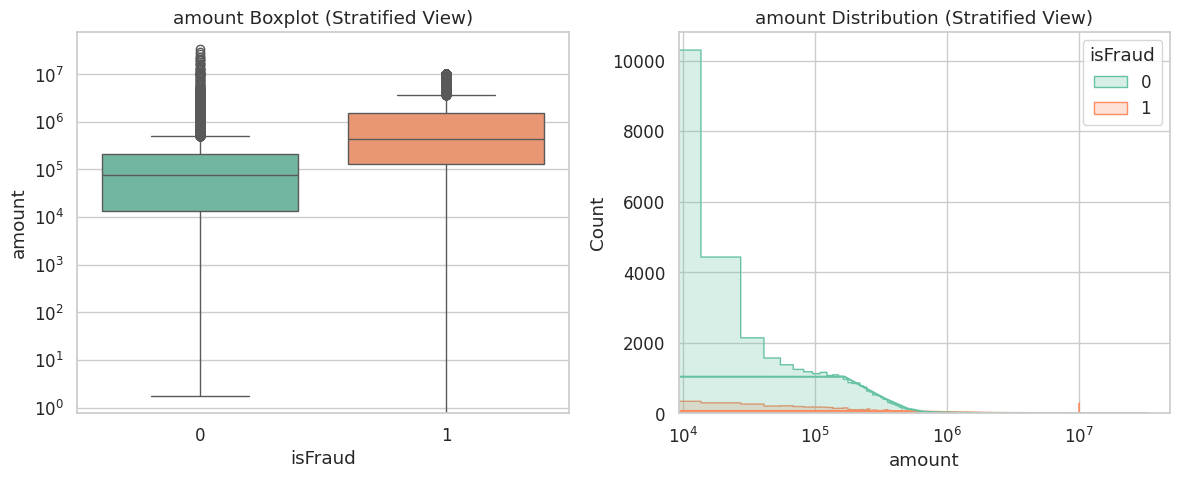

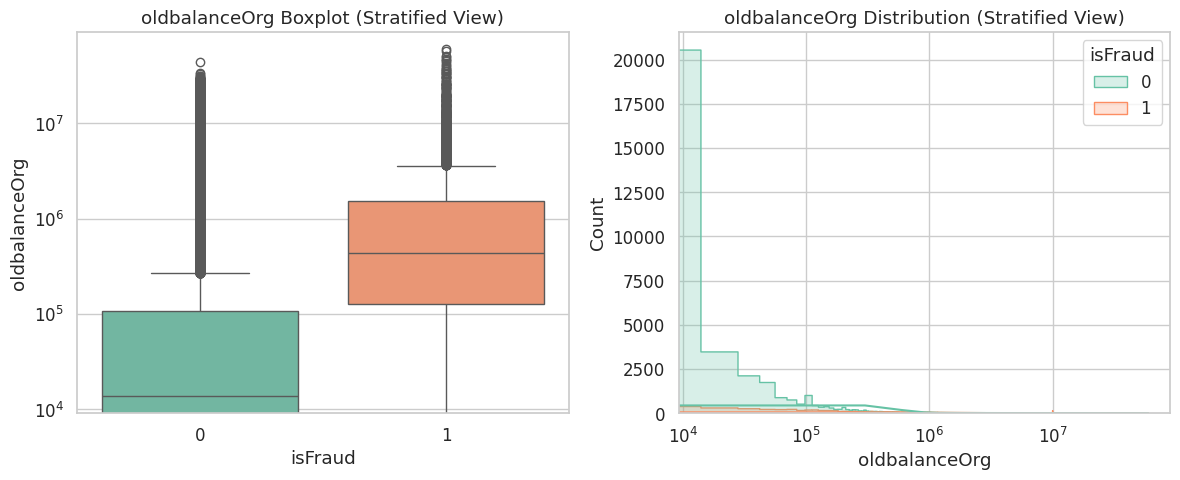

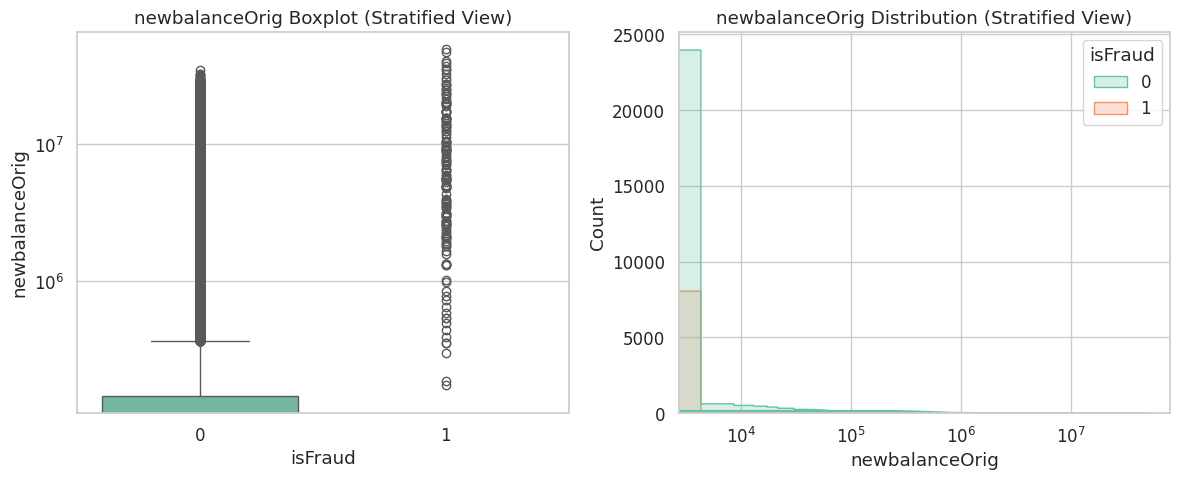


=== 3. CORRELATION ANALYSIS (GPU) ===


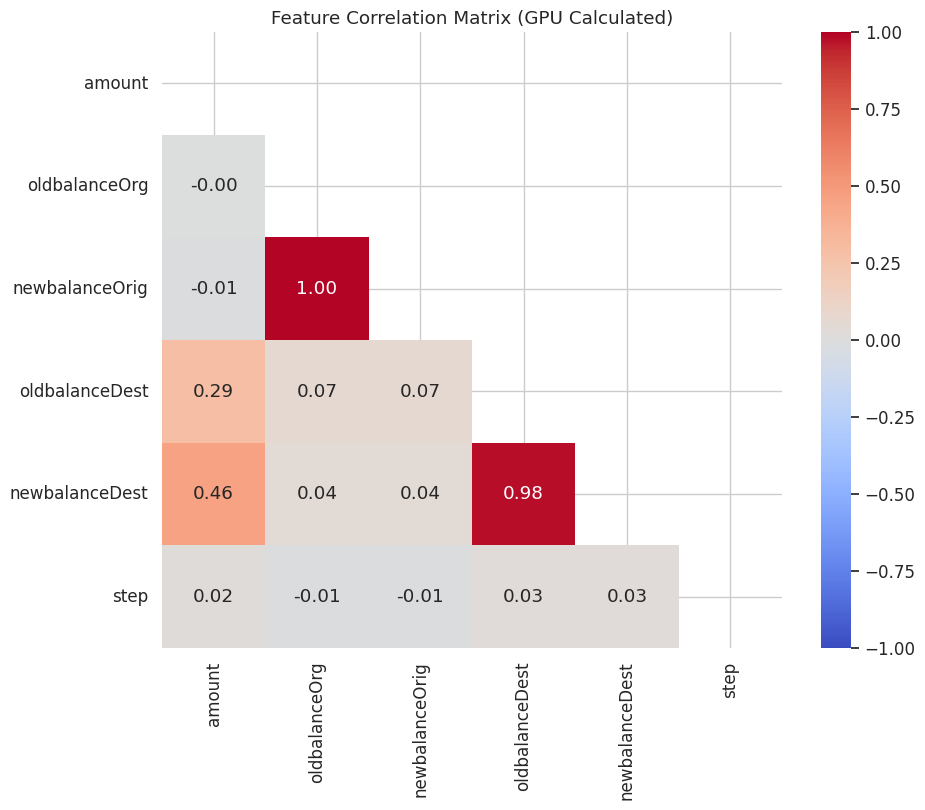

In [4]:
# ---  Code Cell 4: High-Level Profiling ---
print("=== 1. DATASET HEALTH CHECK ===")
health_summary = dataset_health_check(df)

# Check for Duplicate Transactions
duplicates = df.duplicated().sum()
print(f"\nDuplicate Rows: {duplicates}")

# Check for Negative Balances (Financial Logic Violation)
negative_balances = df[(df['oldbalanceOrg'] < 0) | (df['newbalanceOrig'] < 0) | (df['amount'] < 0)]
print(f"Transactions with Negative Values: {len(negative_balances)}")

# Legacy System Check
flagged = df[df['isFlaggedFraud'] == 1]
correct_flags = flagged[flagged['isFraud'] == 1]
# We calculate scalars on CPU for formatting
precision = len(correct_flags) / len(flagged) if len(flagged) > 0 else 0
recall = len(correct_flags) / df['isFraud'].sum()

print(f"\nLegacy System Precision: {precision:.3%} (Flagged {len(flagged)} txns)")
print(f"Legacy System Recall:    {recall:.3%} (Caught {len(correct_flags)} of {df['isFraud'].sum()})")

print("\n=== 2. FEATURE DISTRIBUTIONS (Stratified Seaborn) ===")
cols_to_plot = ['amount', 'oldbalanceOrg', 'newbalanceOrig']
for col in cols_to_plot:
    plot_robust_distribution(df, col, log_scale=True)

print("\n=== 3. CORRELATION ANALYSIS (GPU) ===")
plot_correlation_heatmap(df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'step']])

**Strategic Insight:**

1. **High Cardinality:** `nameOrig` is 99.9% unique. We cannot use User History/Profile features. We must rely on **Transaction Logic**.
2. **Legacy Failure:** The `isFlaggedFraud` column is useless (captures almost nothing). We need a better model.
3. **Skewed Distributions:** Amounts and balances are heavily skewed.
4. **Correlations:**
    * `amount` correlates moderately with balances, as expected. No red flags here.
    * `oldbalanceOrg` and `newbalanceOrig` are strongly correlated: Which suggests that most transactions do not change balances significantly.
        * This is a key insight for our forensic feature engineering: Legitimate transactions should show balance changes consistent with the transaction amount.
        * This may be a signal to noise which needs heavy cleaning.

In [5]:
features_model = set()

## 4. Strategic Scoping & Bivariate Analysis
* We investigate the "Physics" of the transaction: Does `New = Old - Amount`?
* We also filter the dataset to focus only on risk-prone transaction types.

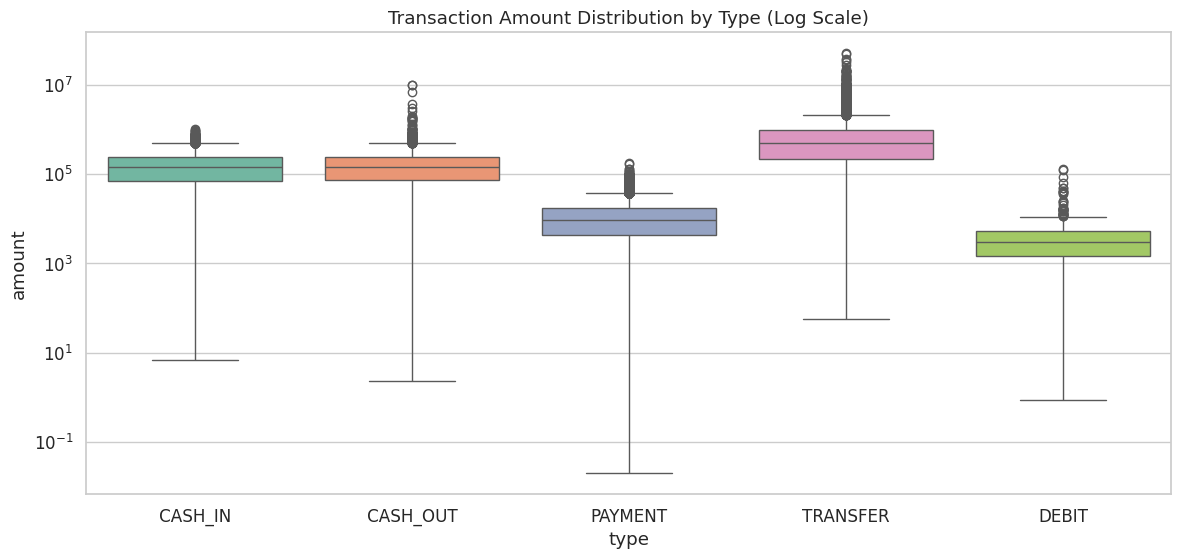

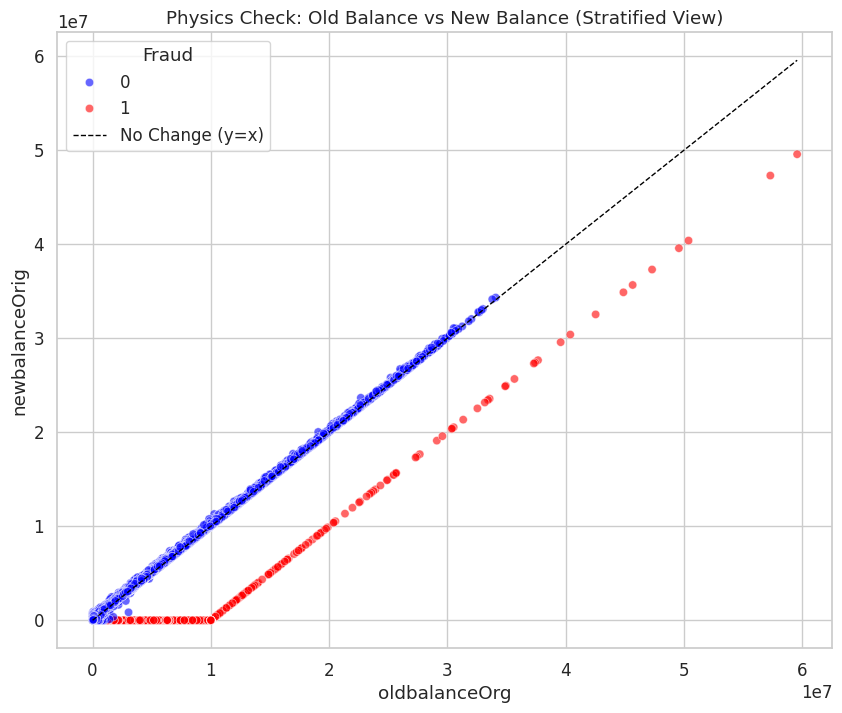

Applying Strategic Filter (TRANSFER + CASH_OUT)...
Focused Dataset Shape: 2770409 rows (Filtered on GPU)


In [6]:
# ---  Code Cell 5: Bivariate: Amount Distribution by Type ---

# We sample on GPU, then convert to CPU for plotting
df_viz = df.sample(min(100000, len(df))).to_pandas()

plt.figure(figsize=(14, 6))
sns.boxplot(x='type', y='amount', data=df_viz, palette="Set2")
plt.yscale('log')
plt.title('Transaction Amount Distribution by Type (Log Scale)')
plt.show()

# --- 2. The Physics Check: Old vs New Balance ---
# Hypothesis: Legitimate transactions sit on the line y = x (or y = x - amount).
# Anomalies will scatter away from the diagonal.
# STRATEGY: Use Stratified Sampling to ensure we see the Fraud cases in the plot!
viz_strat = get_stratified_viz_data(df, target='isFraud', neg_ratio=10)

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='oldbalanceOrg',
    y='newbalanceOrig',
    hue='isFraud', # Color by Fraud to see if they break the physics
    data=viz_strat,
    alpha=0.6,
    palette={0: 'blue', 1: 'red'}
)
# Add Reference Line (y=x)
max_val = viz_strat['oldbalanceOrg'].max()
plt.plot([0, max_val], [0, max_val], 'k--', label='No Change (y=x)', linewidth=1)
plt.title('Physics Check: Old Balance vs New Balance (Stratified View)')
plt.legend(title='Fraud')
plt.show()

# --- 3. Strategic Filter (GPU) ---
# Action: Keep only TRANSFER and CASH_OUT
# This dramatically reduces data size while keeping 100% of frauds.
print("Applying Strategic Filter (TRANSFER + CASH_OUT)...")
risk_df = df[df['type'].isin(['TRANSFER', 'CASH_OUT'])].copy()

# Clear memory
del df
gc.collect()

print(f"Focused Dataset Shape: {len(risk_df)} rows (Filtered on GPU)")

**Decision Point:**

* Fraudsters need to move money *out* of the system.
* The plots confirm that `TRANSFER` and `CASH_OUT` are the primary mechanisms for significant funds movement.
* **Action:** We will filter the dataset to these two types to reduce noise and focus on high-risk vectors.

## 5. Forensic Feature Engineering

### 5.1 The Error Decomposition
* This is a critical phase. We analyze the **Integrity** of the transaction math.
* We hypothesize that fraud involves draining accounts, which mathematically means `Old - Amount = New`.
* The data might contain technical glitches.

#### We decompose the transaction logic to find anomalies.
**Logic Categories:**
1. **Perfect Math:** `Old - New = Amount` (Normal behavior).
2. **Failed Deduction:** `Old == New` (Money didn't leave the account - "Ghost" transaction).
3. **Reverse Logic:** `New > Old` (Money was ADDED instead of subtracted - serious bug/fraud).
4. **Math Gap:** The numbers changed, but not by the transaction amount (Hidden fees? Theft?).

In [7]:
# ---  Code Cell 6: Forensic Feature Engineering: Error Decomposition ---
# 1. Calculate Raw Math Error (Vectorized on GPU)
# Expected: New = Old - Amount
risk_df['actual_change'] = risk_df['oldbalanceOrg'] - risk_df['newbalanceOrig']
risk_df['raw_error'] = risk_df['actual_change'] - risk_df['amount']

# 2. Categorize the Errors (The Forensic Step)
# We use direct boolean assignment (fastest on GPU for strings)
epsilon = 0.01

# Default
risk_df['error_category'] = 'Math Gap'

# Case 3: Reverse Logic (Highest Risk behavior)
risk_df.loc[risk_df['newbalanceOrig'] > risk_df['oldbalanceOrg'], 'error_category'] = 'Reverse Logic'

# Case 2: Failed Deduction (Ghost)
risk_df.loc[risk_df['oldbalanceOrg'] == risk_df['newbalanceOrig'], 'error_category'] = 'Failed Deduction'

# Case 1: Perfect Math (Overwrite everything else if math is perfect)
risk_df.loc[risk_df['raw_error'].abs() < epsilon, 'error_category'] = 'Perfect Math'

# 3. Analyze Fraud Rates by Category (GPU GroupBy)
summary_gpu = risk_df.groupby('error_category').agg(
    count=('amount', 'count'),
    fraud_rate=('isFraud', 'mean')
)

# Move summary to CPU for styling
summary = to_cpu(summary_gpu)

print("=== Logic Category Distribution (Count & Fraud Rate) ===")
display(summary.sort_values('count', ascending=False))

# Calculate Lift
global_fraud_rate = risk_df['isFraud'].mean()
summary['lift'] = summary['fraud_rate'] / global_fraud_rate

print("\n=== Logic Category Analysis (Lift) ===")
print(f"Global Fraud Rate: {global_fraud_rate:.3%}")
display(summary.sort_values('lift', ascending=False).style.background_gradient(cmap='Reds', subset=['lift']))

=== Logic Category Distribution (Count & Fraud Rate) ===


,count,fraud_rate
error_category,,
Failed Deduction,1308585,0.000
Math Gap,1190233,0.000
Perfect Math,271589,0.030
Reverse Logic,2,0.000



=== Logic Category Analysis (Lift) ===
Global Fraud Rate: 0.296%


,count,fraud_rate,lift
error_category,,,
Perfect Math,271589,0.030075,10.144850
Failed Deduction,1308585,0.000031,0.010569
Math Gap,1190233,0.000003,0.001134
Reverse Logic,2,0.000000,0.000000


1. **The "Ghost" Discovery:**
We found a massive number of "Failed Deductions" where `NewBalance == OldBalance` despite `Amount > 0`. If we feed `raw_error` to the model, it will treat these technical glitches as massive frauds. We must "clean" this signal.
2. **The Lift:**
Even thu we cant use it as signal due to the nature of this task - we see most frauds are in the "Perfect Math" section, indicating that fraudsters are careful to maintain balance integrity.

### 5.2 Cleaning & Logic Features

#### We calculate three critical signals:
1. **Clean Error:** Removing "Ghost" transactions to see real math gaps.
2. **Drain Ratio:** Detecting account emptying behavior.
3. **Cyclical Time:** Handling the 24h cycle correctly.


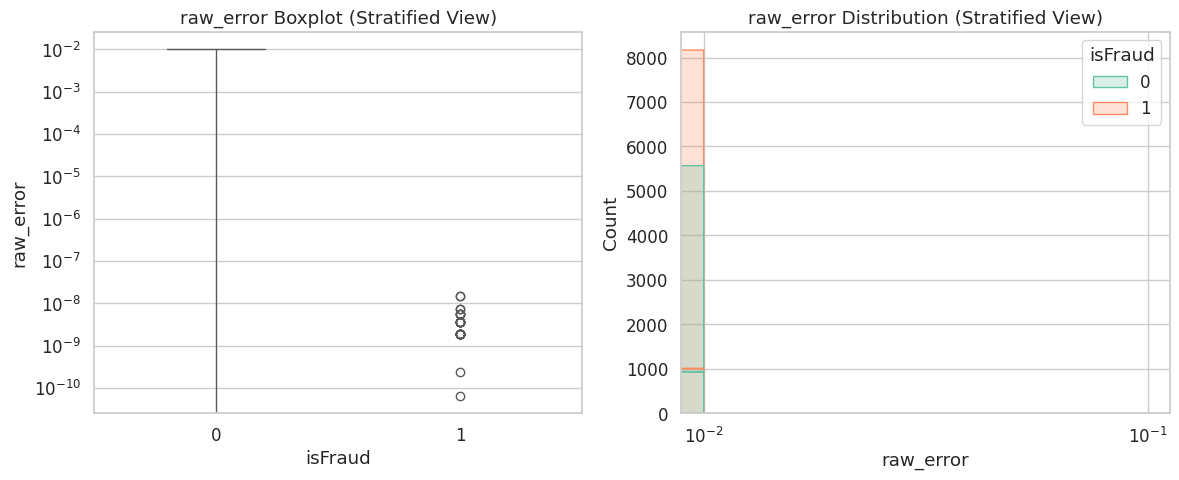

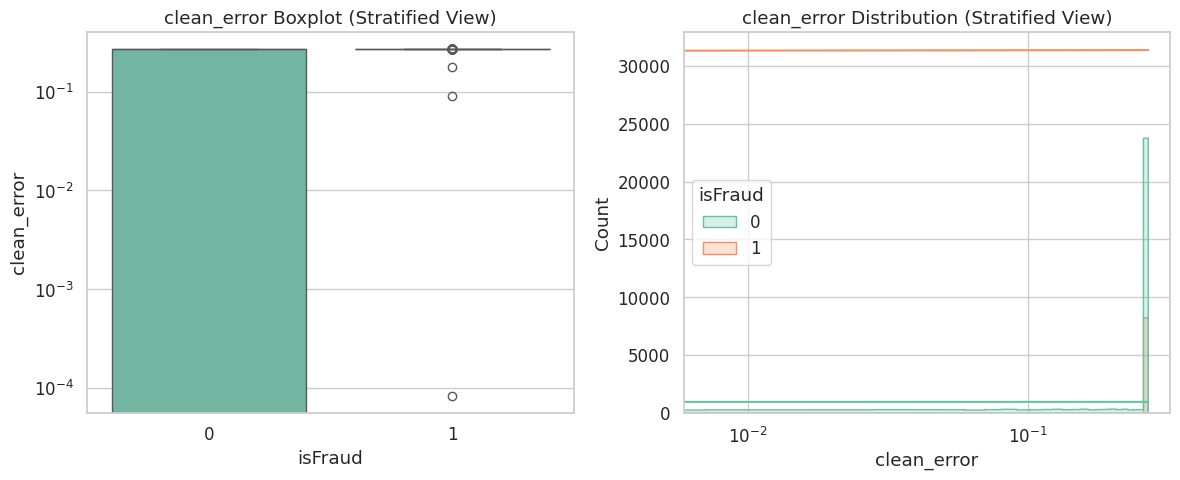

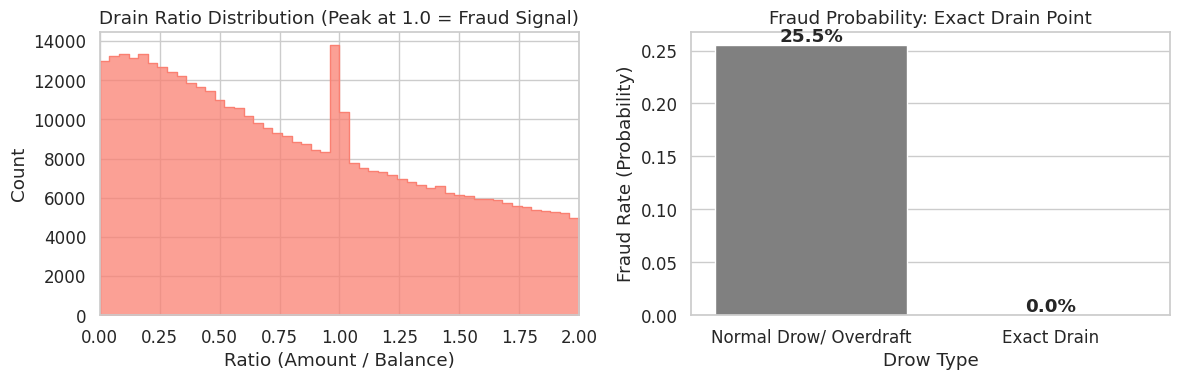

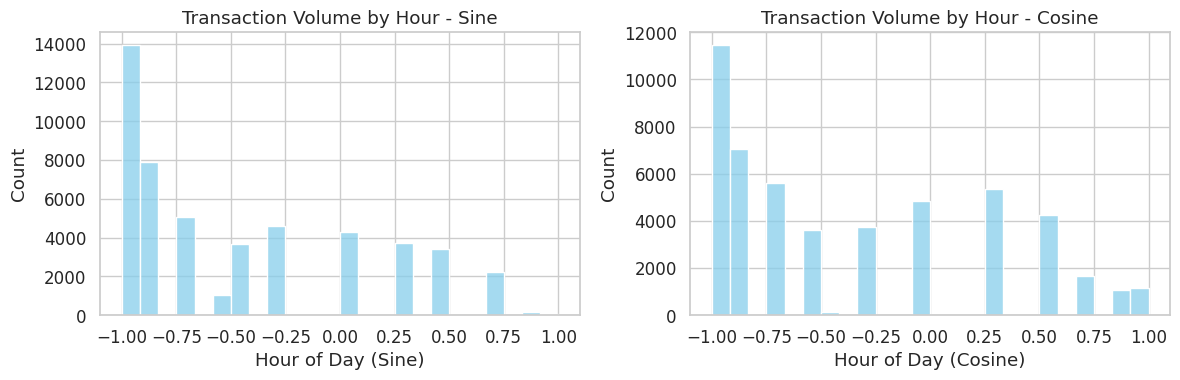

Forensic Features Calculated.


In [8]:
# ---  Code Cell 7: Forensic Features Engineering ---
# --- 1. Feature: Clean Error (Zero out Ghosts) ---
# Discussion: We noticed "Failed Deductions" (Old=New) create massive noise in the error metric.
# We set their error to 0.0 to focus on "Math Gaps" (where money actually moved but math is wrong).

# Logic (GPU Vectorized)
cond_failed = (risk_df['oldbalanceOrg'] == risk_df['newbalanceOrig'])
risk_df['clean_error'] = risk_df['raw_error'].copy()
# Zero out the ghosts
risk_df.loc[cond_failed, 'clean_error'] = 0.0
# Scaling (Hybrid)
if SVM_TYPE == "GPU": # Using cuml scaler if available
    scaler = StandardScaler()
    risk_df.loc[:, 'clean_error'] = scaler.fit_transform(risk_df['clean_error'].values.reshape(-1, 1))
else:
    scaler = StandardScaler()
    risk_df.loc[:, 'clean_error'] = scaler.fit_transform(risk_df['clean_error'].to_pandas().values.reshape(-1, 1))

# VALIDATION:
cols_to_plot = ['raw_error', 'clean_error']
log_scales = [True, True]
for col, log_scale in zip(cols_to_plot, log_scales):
    plot_robust_distribution(risk_df, col, log_scale=log_scale)

# --- 2. Feature: Drain Ratio ---
# Hypothesis: Normal users leave money. Fraudsters drain it all (Ratio ~ 1.0).
# Calculation: Amount / OldBalance
risk_df['drain_ratio'] = risk_df['amount'] / (risk_df['oldbalanceOrg'] + 1.0)
risk_df['is_exc_drain'] = ((risk_df['drain_ratio'] > 0.98) & (risk_df['drain_ratio'] <= 1.1)).astype(int)

# VALIDATION: Histogram & Fraud Rate
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(risk_df.loc[risk_df['drain_ratio'] <= 2, 'drain_ratio'].to_pandas(), bins=50, color='salmon', element="step")
plt.title('Drain Ratio Distribution (Peak at 1.0 = Fraud Signal)')
plt.xlabel('Ratio (Amount / Balance)')
plt.xlim(0, 2)    # limit x-axis to see the peak clearly

plt.subplot(1, 2, 2)
flow_stats = risk_df.groupby('is_exc_drain')['isFraud'].mean().to_pandas()
flow_stats.index = ['Normal Drow/ Overdraft', 'Exact Drain']

sns.barplot(x=flow_stats.index, y=flow_stats.values, palette=['gray', 'red'])
plt.title("Fraud Probability: Exact Drain Point")
plt.ylabel("Fraud Rate (Probability)")
plt.xlabel("Drow Type")
for i, v in enumerate(flow_stats.values):
    plt.text(i, v, f"{v:.1%}", ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# --- 3. Feature: Cyclical Time ---
# Hypothesis: Fraud might happen at odd hours.
# Convert linear 'step' (hours) into cyclical sine/cosine signals.
# NOTE: Using 'cp' (CuPy) to keep calculation on GPU.
risk_df['hour'] = risk_df['step'] % 24
risk_df['sin_hour'] = cp.sin(2 * cp.pi * risk_df['hour'] / 24)
risk_df['cos_hour'] = cp.cos(2 * cp.pi * risk_df['hour'] / 24)

# VALIDATION: Time Distribution
# Move cols to CPU for plotting
viz_time = risk_df[['sin_hour', 'cos_hour']].sample(min(50000, len(risk_df))).to_pandas()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(viz_time['sin_hour'], bins=24, kde=False, color='skyblue')
plt.title('Transaction Volume by Hour - Sine')
plt.xlabel('Hour of Day (Sine)')

plt.subplot(1, 2, 2)
sns.histplot(viz_time['cos_hour'], bins=24, kde=False, color='skyblue')
plt.title('Transaction Volume by Hour - Cosine')
plt.xlabel('Hour of Day (Cosine)')

plt.tight_layout()
plt.show()

print("Forensic Features Calculated.")

### A Validation Gate (Forensic Feature Audit)
* We test the discriminatory power of our new engineering features.
* We look for High Recall @ 1% (meaning the feature sorts frauds to the top).

In [9]:
# ---  Code Cell 8: Forensic Feature Audit ---
print("=== FEATURE AUDIT: Forensic Features ===")
audit_results = {
    'Clean Error (Signal)': audit_feature(risk_df, 'clean_error'),
    'Drain Ratio': audit_feature(risk_df, 'is_exc_drain'),
}

# Display results formatted as percentages
print("\n--- Audit Summary ---")
print(pd.Series(audit_results).sort_values(ascending=False).apply(lambda x: f"{x:.2%}"))

=== FEATURE AUDIT: Forensic Features ===
[clean_error         ] Recall @ 1%: 0.41% | Precision: 0.12%
[is_exc_drain        ] Recall @ 1%: 66.26% | Precision: 19.64%

--- Audit Summary ---
Drain Ratio             66.26%
Clean Error (Signal)     0.41%
dtype: object


discussion:
The cyclical features show distinct patterns, indicating that transaction behavior varies by time of day. This validates the inclusion of `sin_hour` and `cos_hour` as features in our model.

In [10]:
features_model = features_model.union(['clean_error', 'drain_ratio', 'sin_hour', 'cos_hour', 'is_exc_drain', 'amount'])

## 6. Network Forensics & The "Graph-Lite" Theory

Here we bridge the gap between **Graph Theory** and **Vectorized Engineering**.

### The Concept
In a full Graph implementation, every User is a Node, and every Transaction is an Edge.
* **Mule Account:** A Node with high **In-Degree** (Many incoming edges) and usually low Out-Degree (until cashout).
* **Launderer:** A Node with high **Out-Degree** (Sending to many distinct nodes).

We treat the data as a Graph (Nodes & Edges) to find suspicious patterns:
  > we calculate these topological properties directly using pandas aggregations.

### The Features
1. **Mule Score (In-Degree):** How many people send money to this account?
2. **Spammer Score (Out-Degree):** How active is the sender?
3. **Mule Ratio:** Are the sources unique? (Fan-in vs Clique).
4. **Velocity:** Time gap between transactions for the same receiver.

Calculating Network Features on GPU...
Network Engineering Complete.
Generating Stratified Visualization...


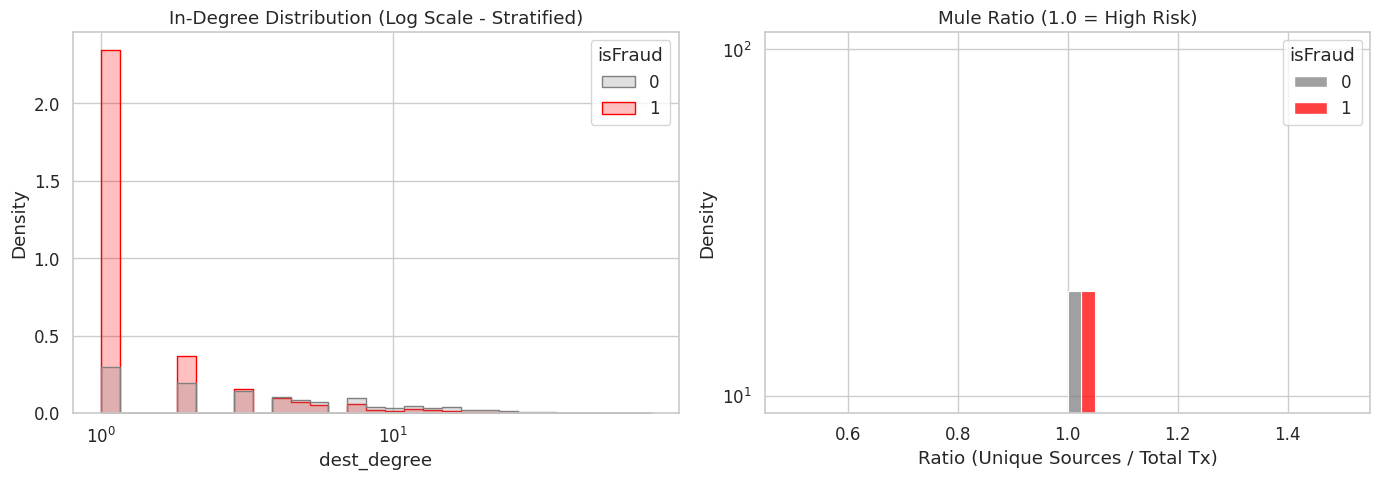

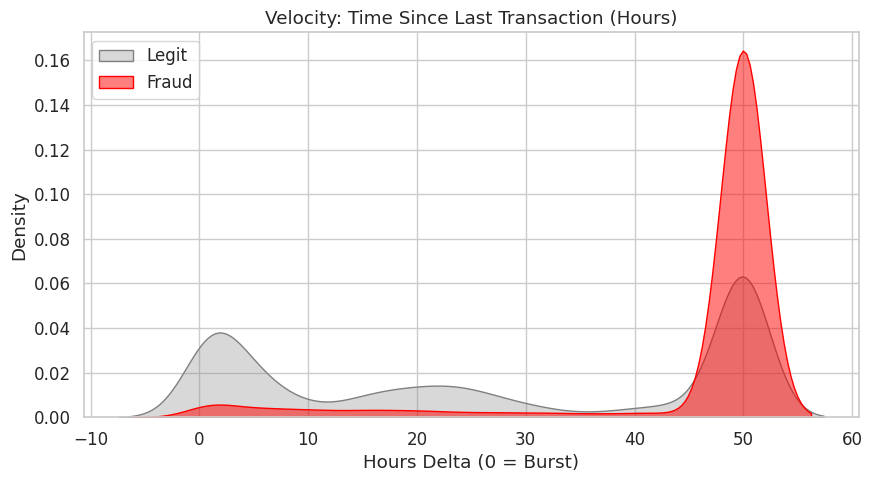

In [11]:
# ---  Code Cell 9: Network Forensic Features ---
print("Calculating Network Features on GPU...")

# 1. Mule Score (In-Degree)
# Concept: Centrality. How central is this node in the receiving network?
risk_df['dest_degree'] = risk_df.groupby('nameDest')['step'].transform('count')

# 2. Spammer Score (Out-Degree)
# Concept: Activity. How active is this node in the sending network?
risk_df['orig_degree'] = risk_df.groupby('nameOrig')['step'].transform('count')

# 3. The "Stranger Danger" Score (Unique Sources)
# Concept: Diversity. Does the money come from a clique or disparate sources?
unique_src = risk_df.groupby('nameDest')['nameOrig'].nunique()

# 4. The Ratio (The "Concentration" Logic)
# Merge on GPU is super fast
risk_df = risk_df.merge(unique_src.rename('dest_unique_src'), on='nameDest', how='left')
risk_df['mule_ratio'] = risk_df['dest_unique_src'] / risk_df['dest_degree']

# 5. VELOCITY (The "Burst" Feature)
# We calculate the time gap between transactions for the same recipient.
# Logic: Sort -> Group -> Diff
risk_df = risk_df.sort_values(['nameDest', 'step'])
# fillna(999): The first transaction has no "previous". 999 hours gap = Safe.
risk_df['step_diff'] = risk_df.groupby('nameDest')['step'].diff().fillna(999)

print("Network Engineering Complete.")

# --- VALIDATION: The "Mule Signal" ---
# Strategy: Use Stratified Sampling (All Frauds + Sample of Legit) for Seaborn plotting.
print("Generating Stratified Visualization...")
viz_strat = get_stratified_viz_data(risk_df, target='isFraud', neg_ratio=5)

plt.figure(figsize=(14, 5))

# Plot 1: In-Degree (Log Scale Histogram)
plt.subplot(1, 2, 1)
# Create log bins based on the CPU sample data
max_deg = viz_strat['dest_degree'].max()
bins_deg = np.logspace(np.log10(1), np.log10(max_deg+1), 30)

sns.histplot(
    data=viz_strat, x='dest_degree', hue='isFraud', bins=bins_deg,
    stat="density", common_norm=False, element="step", palette={0:'gray', 1:'red'}
)
plt.xscale('log')
plt.title("In-Degree Distribution (Log Scale - Stratified)")

# Plot 2: Mule Ratio
plt.subplot(1, 2, 2)
sns.histplot(
    data=viz_strat, x='mule_ratio', hue='isFraud', bins=20,
    stat="density", common_norm=False, multiple="dodge", palette={0:'gray', 1:'red'}
)
plt.title("Mule Ratio (1.0 = High Risk)")
plt.yscale('log') # Log scale on Y to see the small bars of frauds
plt.xlabel("Ratio (Unique Sources / Total Tx)")

plt.tight_layout()
plt.show()

# Plot 3: Velocity
plt.figure(figsize=(10, 5))
# Clip at 50 hours to see the "bursts" at 0 clearly
sns.kdeplot(viz_strat[viz_strat['isFraud']==0]['step_diff'].clip(0, 50), label='Legit', fill=True, color='gray', alpha=0.3)
sns.kdeplot(viz_strat[viz_strat['isFraud']==1]['step_diff'].clip(0, 50), label='Fraud', fill=True, color='red', alpha=0.5)
plt.title("Velocity: Time Since Last Transaction (Hours)")
plt.xlabel("Hours Delta (0 = Burst)")
plt.legend()
plt.show()

### 6b. SNA Engine: The "Hidden Structures" Graph Features
Here we treat the data as a Network to capture hidden structures.

**Key Concepts:**
1. **Connected Components:** Identifying isolated "Islands" of fraud.
2. **PageRank:** Identifying central hubs.
3. **Fast Flow (Mule Loop):** Identifying "Hot Potato" money movement (In -> Out in < 1h).

=== INITIALIZING SNA ENGINE (GPU) ===
Mapping Node IDs...
Nodes Mapped. Total Unique Nodes: 3277509
Graph Built: 3277509 nodes, 2770409 edges.
Calculating Connected Components (WCC)...
Calculating PageRank...
Calculating Rapid Flow (Mule Logic) using IDs...
SNA Feature Engineering Complete.


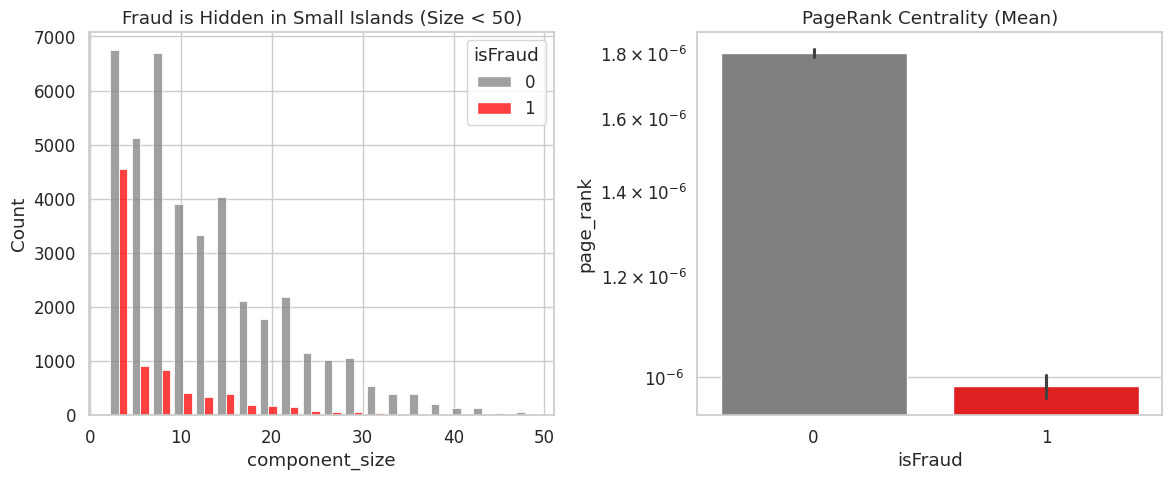

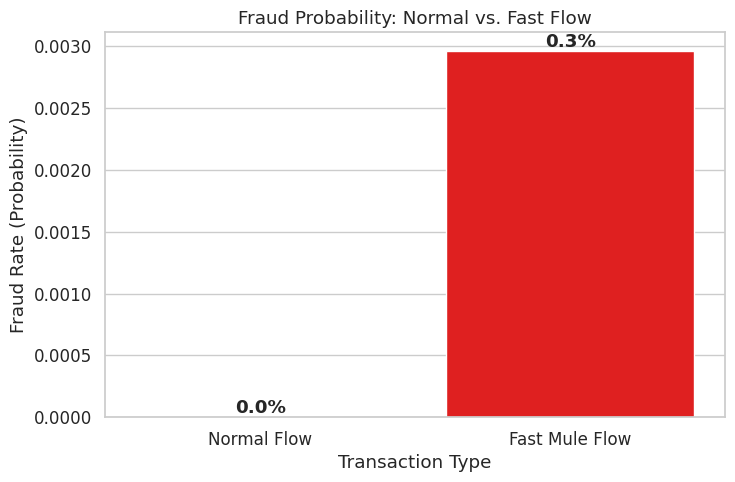

In [12]:
# ---  Code Cell 10: Network Graph "Hidden Structures" Features ---

print("=== INITIALIZING SNA ENGINE (GPU) ===")

# --- 1. Graph Construction Prep ---
print("Mapping Node IDs...")
all_users = cudf.concat([risk_df['nameOrig'], risk_df['nameDest']]).unique()
user_map = cudf.DataFrame()
user_map['node_name'] = all_users
user_map['node_id'] = user_map.index.astype('int32')

risk_df = risk_df.merge(user_map, left_on='nameOrig', right_on='node_name', how='left')
risk_df = risk_df.rename(columns={'node_id': 'src_id'}).drop(columns=['node_name'])

risk_df = risk_df.merge(user_map, left_on='nameDest', right_on='node_name', how='left')
risk_df = risk_df.rename(columns={'node_id': 'dst_id'}).drop(columns=['node_name'])

print(f"Nodes Mapped. Total Unique Nodes: {len(user_map)}")

# Build Directed Graph (For PageRank)
G = cugraph.Graph(directed=True)
edge_data = risk_df[['src_id', 'dst_id', 'amount']]
G.from_cudf_edgelist(edge_data, source='src_id', destination='dst_id', edge_attr='amount')

print(f"Graph Built: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")


# --- 2. The "Genius" Feature: Weakly Connected Components (Islands) ---
print("Calculating Connected Components (WCC)...")

# WCC requires an Undirected Graph
# We create a temporary Undirected view/copy just for this algorithm
G_undirected = cugraph.Graph(directed=False)
G_undirected.from_cudf_edgelist(edge_data, source='src_id', destination='dst_id', edge_attr='amount')

wcc_df = cugraph.weakly_connected_components(G_undirected)
# wcc_df columns: ['labels' (component_id), 'vertex' (node_id)]

# Calculate Size of each component
comp_sizes = wcc_df.groupby('labels')['vertex'].count().reset_index()
comp_sizes.columns = ['labels', 'component_size']

# Merge size back
wcc_info = wcc_df.merge(comp_sizes, on='labels', how='left')
wcc_info = wcc_info.rename(columns={'labels': 'component_id', 'vertex': 'node_id'})

# Merge to main df
risk_df = risk_df.merge(
    wcc_info[['node_id', 'component_size']],
    left_on='dst_id',
    right_on='node_id',
    how='left'
).drop(columns=['node_id'])

# --- 3. Centrality: PageRank ---
print("Calculating PageRank...")
# Use the DIRECTED graph G for PageRank; 'alpha' marks the "Damping Factor": 1 - 'alpha' is the "random-jump" chance.
pr_df = cugraph.pagerank(G, alpha=0.75)
pr_df = pr_df.rename(columns={'pagerank': 'page_rank', 'vertex': 'node_id'})

risk_df = risk_df.merge(
    pr_df,
    left_on='dst_id',
    right_on='node_id',
    how='left'
).drop(columns=['node_id'])


# --- 4. Time-Based Logic: The "Fast Flow" (Optimized) ---
print("Calculating Rapid Flow (Mule Logic) using IDs...")

# 1. Who received money and when? (Using integer IDs for speed)
# We rename columns to generic 'node_id' to facilitate the join later.
inbound = risk_df[['dst_id', 'step']].rename(
    columns={'dst_id': 'node_id', 'step': 'step_in'}
)

# 2. Who sent money and when?
outbound = risk_df[['src_id', 'step']].rename(
    columns={'src_id': 'node_id', 'step': 'step_out'}
)

# 3. Find nodes that BOTH received AND sent funds (Self-Join / Local Cartesian)
# This creates all possible Input-Output pairs for every user.
# Inner Join filters out users who only received or only sent (irrelevant for flow).
flow_check = inbound.merge(outbound, on='node_id', how='inner')

# 4. The Critical Filter: Did the exit happen immediately after entry?
# Logic: We look for "Hot Potato" behavior.
# Condition: (Time Out >= Time In) AND (Time Out <= Time In + 1 step)
fast_flow = flow_check[
    (flow_check['step_out'] >= flow_check['step_in']) &
    (flow_check['step_out'] <= flow_check['step_in'] + 1)
]

# 5. Flag suspicious transactions in the main dataset
# We flag the *OUTGOING* transaction (The Mule's action of moving funds out).
suspicious_sends = fast_flow[['node_id', 'step_out']].drop_duplicates()
suspicious_sends['is_mule_flow'] = 1

# Merge back to the main DataFrame
risk_df = risk_df.merge(
    suspicious_sends,
    left_on=['src_id', 'step'],    # Join based on the Sender and the Time they sent
    right_on=['node_id', 'step_out'],
    how='left'
).drop(columns=['node_id', 'step', 'step_out', 'nameOrig', 'nameDest'])

# Fill non-matches with 0
risk_df['is_mule_flow'] = risk_df['is_mule_flow'].fillna(0)

print("SNA Feature Engineering Complete.")

# --- VALIDATION ---
viz_strat = get_stratified_viz_data(risk_df, target='isFraud', neg_ratio=5)

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
small_comps = viz_strat[viz_strat['component_size'] < 50]
sns.histplot(data=small_comps, x='component_size', hue='isFraud',
             multiple="dodge", shrink=.8, palette={0:'gray', 1:'red'}, bins=20)
plt.title("Fraud is Hidden in Small Islands (Size < 50)")

plt.subplot(1, 3, 2)
sns.barplot(data=viz_strat, x='isFraud', y='page_rank', palette={'0':'gray', '1':'red'})
plt.title("PageRank Centrality (Mean)")
plt.yscale('log')

plt.tight_layout()
plt.show()

# --- VALIDATION: Mule Flow Impact ---
plt.figure(figsize=(8, 5))
# Calculate fraud rate for Mule Flow vs Normal
flow_stats = risk_df.groupby('is_mule_flow')['isFraud'].mean().to_pandas()
flow_stats.index = ['Normal Flow', 'Fast Mule Flow']

sns.barplot(x=flow_stats.index, y=flow_stats.values, palette=['gray', 'red'])
plt.title("Fraud Probability: Normal vs. Fast Flow")
plt.ylabel("Fraud Rate (Probability)")
plt.xlabel("Transaction Type")
for i, v in enumerate(flow_stats.values):
    plt.text(i, v, f"{v:.1%}", ha='center', va='bottom', fontweight='bold')
plt.show()

### A Validation Gate (Feature Audit: Graph/Network Features)
* Checking if our graph-based features successfully isolate high-risk behavior.

In [13]:
# ---  Code Cell 11: AUDIT: Graph Features Impact ---
print("=== FEATURE AUDIT: Graph/Network Features ===")

# audit_feature handles GPU/CPU internally
audit_results_graph = {
    'In-Degree (Dest Count)': audit_feature(risk_df, 'dest_degree'),
    'Mule Ratio (Density)': audit_feature(risk_df, 'mule_ratio'),
    'Out-Degree (Orig Count)': audit_feature(risk_df, 'orig_degree'),
    'Mule Flow (Hot Potato)': audit_feature(risk_df, 'is_mule_flow'), # Expect High Recall
    'Component Size (Small)': audit_feature(risk_df, 'component_size', invert=True), # Small = Risk
    'PageRank (Centrality)': audit_feature(risk_df, 'page_rank'),
    # Note: Low diff (burst) is risky, so we invert the sort logic
    'Velocity (Burst)': audit_feature(risk_df, 'step_diff', invert=True),
}

print("\n--- Network Audit Summary ---")
print(pd.Series(audit_results_graph).sort_values(ascending=False).apply(lambda x: f"{x:.2%}"))

=== FEATURE AUDIT: Graph/Network Features ===
[dest_degree         ] Recall @ 1%: 0.38% | Precision: 0.11%
[mule_ratio          ] Recall @ 1%: 1.05% | Precision: 0.31%
[orig_degree         ] Recall @ 1%: 1.11% | Precision: 0.33%
[is_mule_flow        ] Recall @ 1%: 1.05% | Precision: 0.31%
[component_size      ] Recall @ 1%: 8.22% | Precision: 2.44%
[page_rank           ] Recall @ 1%: 0.38% | Precision: 0.11%
[step_diff           ] Recall @ 1%: 0.09% | Precision: 0.03%

--- Network Audit Summary ---
Component Size (Small)     8.22%
Out-Degree (Orig Count)    1.11%
Mule Ratio (Density)       1.05%
Mule Flow (Hot Potato)     1.05%
In-Degree (Dest Count)     0.38%
PageRank (Centrality)      0.38%
Velocity (Burst)           0.09%
dtype: object


In [14]:
features_model = features_model.union(['orig_degree', 'dest_degree', 'mule_ratio', 'component_size', 'page_rank'])

## 7. The Manifold Check: t-SNE & 3D-PCA Projection

### t-SNE: Visualizing High-Dimensional Fraud Patterns

Standard scatter plots only show 2 dimensions. Fraud implies a "break" in the correlation structure across many dimensions.

To visualize this, we use **t-SNE (t-Distributed Stochastic Neighbor Embedding)**.
t-SNE takes our high-dimensional feature space (Math Error, Drain, Time, Network) and projects it down to 2D while trying to preserve "neighborhoods".

**Hypothesis:** If our features are good, Frauds should cluster together in a distinct "island" or "filament" separate from the main blob of legitimate transactions.

Preparing t-SNE Data (Mode: GPU)...
Running t-SNE on 36000 samples...
[W] [16:41:50.378151] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
Visualizing t-SNE...


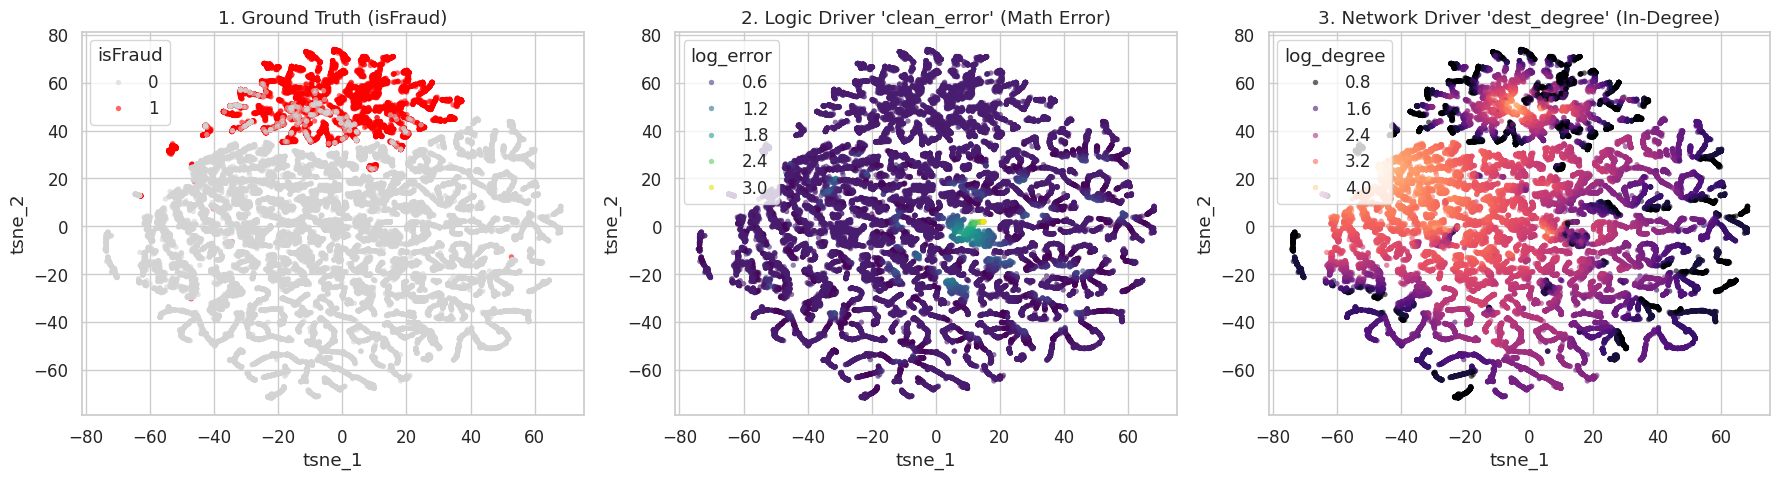

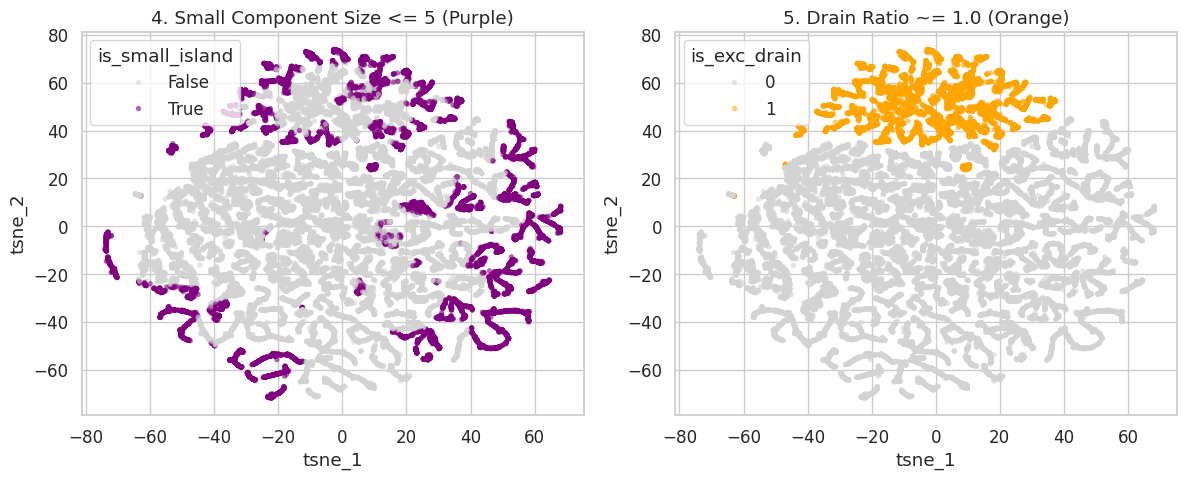

In [15]:
# ---  Code Cell 12: t-SNE Projection & Visualization ---
print(f"Preparing t-SNE Data (Mode: {DIM_RED_TYPE})...")

# 1. Prepare Data using Stratified Sampling
# Filter on GPU
frauds = risk_df[risk_df['isFraud'] == 1]
legits = risk_df[risk_df['isFraud'] == 0]

# Sampling Logic
n_sample_total = 36000
n_fraud = len(frauds)
# Take up to 6000 frauds, rest legit
n_fraud_take = min(n_fraud, 6000)
n_legit_take = n_sample_total - n_fraud_take

# Sample and Concat
sample_fraud = frauds.sample(n=n_fraud_take, random_state=SEED)
sample_legit = legits.sample(n=n_legit_take, random_state=SEED)
proj_df = cudf.concat([sample_fraud, sample_legit])

# Fill NA on GPU
X_proj = proj_df[list(features_model)].fillna(0)

# 2. Scaling (Hybrid)
if SVM_TYPE == "GPU": # Using cuml scaler if available
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_proj)
else:
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_proj.to_pandas())

# 3. Run t-SNE (Hybrid)
print(f"Running t-SNE on {len(proj_df)} samples...")
perplexity_ = 40
if DIM_RED_TYPE == "GPU":
    # Note! n_neighbors should be ~3x perplexity to avoid warnings
    tsne = TSNE(n_components=2, perplexity=perplexity_, n_neighbors=int(3 * perplexity_), random_state=SEED)
    X_embedded = tsne.fit_transform(X_scaled)
else:
    tsne = TSNE(n_components=2, perplexity=perplexity_, random_state=SEED, n_jobs=-1, init='pca', learning_rate='auto')
    X_embedded = tsne.fit_transform(to_cpu(X_scaled))

# --- Robust GPU to CPU Conversion ---
proj_df = to_cpu(proj_df)          # Convert DataFrame to Pandas
X_embedded = to_cpu(X_embedded)    # Convert Embedding to Numpy/Pandas

# Ensure X_embedded is numpy array for slicing
if hasattr(X_embedded, 'values'):
    X_embedded = X_embedded.values

proj_df['tsne_1'] = X_embedded[:, 0]
proj_df['tsne_2'] = X_embedded[:, 1]

# 4. Visualize
print("Visualizing t-SNE...")
plt.figure(figsize=(18, 5))

# Plot A: The Truth (Where is the Fraud?)
plt.subplot(1, 3, 1)
sns.scatterplot(data=proj_df, x='tsne_1', y='tsne_2', hue='isFraud',
                palette={0:'lightgray', 1:'red'}, alpha=0.6, s=15, linewidth=0)
plt.title("1. Ground Truth (isFraud)")

# Plot B: The Logic Driver (Clean Error)
plt.subplot(1, 3, 2)
proj_df['log_error'] = np.log1p(proj_df['clean_error'].abs())
sns.scatterplot(data=proj_df, x='tsne_1', y='tsne_2', hue='log_error',
                palette='viridis', alpha=0.6, s=15, linewidth=0)
plt.title("2. Logic Driver 'clean_error' (Math Error)")

# Plot C: The Network Driver (In-Degree)
plt.subplot(1, 3, 3)
proj_df['log_degree'] = np.log1p(proj_df['dest_degree'])
sns.scatterplot(data=proj_df, x='tsne_1', y='tsne_2', hue='log_degree',
                palette='magma', alpha=0.6, s=15, linewidth=0)
plt.title("3. Network Driver 'dest_degree' (In-Degree)")

plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 5))

# Plot D: The "Island" Behavior (Fraudsters act in small groups)
plt.subplot(1, 3, 1)
# We focus on small components (size < 10)
proj_df['is_small_island'] = proj_df['component_size'] <= 5
sns.scatterplot(data=proj_df, x='tsne_1', y='tsne_2', hue='is_small_island',
                palette={False:'lightgray', True:'purple'}, alpha=0.6, s=15, linewidth=0)
plt.title("4. Small Component Size <= 5 (Purple)")

# Plot E: The "Drain" Behavior (Fraudsters empty the account)
plt.subplot(1, 3, 2)
# Create a binary color for drain ratio close to 1
sns.scatterplot(data=proj_df, x='tsne_1', y='tsne_2', hue='is_exc_drain',
                palette={False:'lightgray', True:'orange'}, alpha=0.6, s=15, linewidth=0)
plt.title("5. Drain Ratio ~= 1.0 (Orange)")

plt.tight_layout()
plt.show()

### The 3D PCA Manifold (Unified Analysis)
We expand the projection to 3 dimensions to find hyper-plane separation.
**Includes:**
1. 3D PCA Calculation (GPU).
2. Feature Importance Analysis (Loadings).
3. Multi-Angle Visualization (Static 3D).

Calculating PCA (GPU Mode: GPU)...
Features used (11): ['amount', 'clean_error', 'component_size', 'cos_hour', 'dest_degree', 'drain_ratio', 'is_exc_drain', 'mule_ratio', 'orig_degree', 'page_rank', 'sin_hour']
   > Running PCA on GPU (cuML)...
Explained Variance: 59.31%


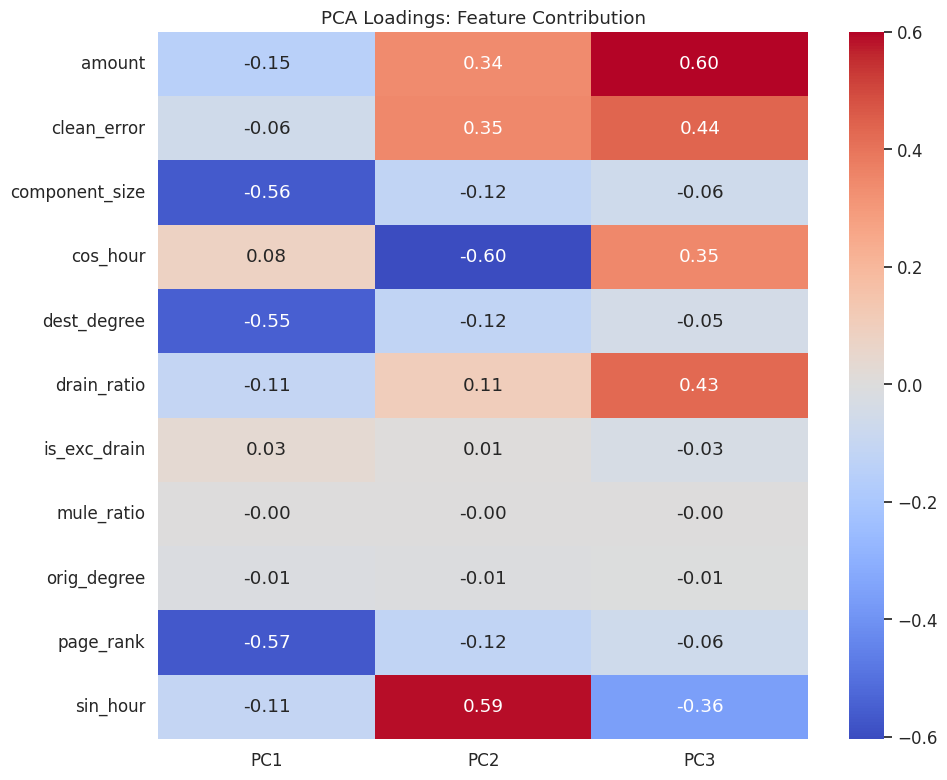

Generating 3D Manifold View...


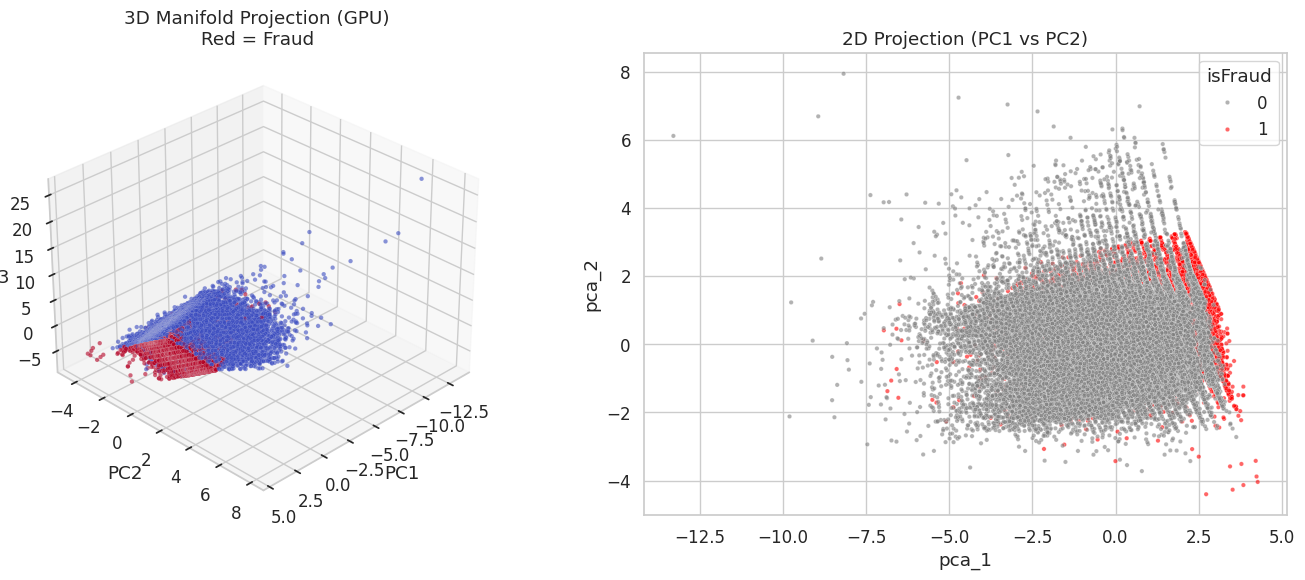

In [16]:
# --- Code Cell 13: PCA Visualization (Restored & Fixed) ---


print(f"Calculating PCA (GPU Mode: {DIM_RED_TYPE})...")

# 1. Freeze Column Order (Critical for Heatmap Alignment)
# Sort the list to ensure constant order every run
cols_ordered = sorted(list(features_model))
# Filter to ensure we only use columns that exist in the dataframe
cols_ordered = [c for c in cols_ordered if c in risk_df.columns]

print(f"Features used ({len(cols_ordered)}): {cols_ordered}")

# 2. Data Prep
# Create a working copy. If risk_df is cuDF, this keeps it on GPU initially.
X = risk_df[cols_ordered].fillna(0)

# --- 3. Log Transformation (Handling Skew) ---
# We log-transform specific heavy-tailed features to improve PCA separation
cols_to_log = ['amount', 'clean_error', 'dest_degree', 'orig_degree', 'step_diff']

# Check if X is cuDF or Pandas and apply log1p accordingly
if hasattr(X, 'to_pandas'): # It's a GPU DataFrame
    for col in cols_to_log:
        if col in X.columns:
            X[col] = cp.log1p(X[col].abs())
else: # It's a CPU DataFrame
    for col in cols_to_log:
        if col in X.columns:
            X[col] = np.log1p(X[col].abs())

# --- 4. Scale & PCA Logic ---
if DIM_RED_TYPE:
    # --- GPU PATH (RAPIDS) ---
    print("   > Running PCA on GPU (cuML)...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X_scaled)

    # Extract components to Host (CPU) for plotting
    # .components_ in cuML is a generic array, needs careful handling
    components = pca.components_
    if hasattr(components, 'get'):
        components = components.get()
    elif hasattr(components, 'to_numpy'):
        components = components.to_numpy()

    # Extract transformed data to Host
    if hasattr(X_pca, 'to_numpy'):
        X_pca_vals = X_pca.to_numpy()
    elif hasattr(X_pca, 'get'):
        X_pca_vals = X_pca.get()
    else:
        X_pca_vals = X_pca.values # fallback

    # Get Explained Variance
    expl_var = pca.explained_variance_ratio_.sum()
    if hasattr(expl_var, 'item'): expl_var = expl_var.item()

else:
    # --- CPU PATH (Sklearn) ---
    print("   > Running PCA on CPU (Sklearn)...")
    # Convert to CPU safely using the helper function
    X_cpu = to_cpu(X)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_cpu)

    pca = PCA(n_components=3, random_state=SEED)
    X_pca_vals = pca.fit_transform(X_scaled)
    components = pca.components_
    expl_var = pca.explained_variance_ratio_.sum()

# 5. Assign results back to DataFrame
# We assign using numpy arrays to avoid index misalignment
risk_df['pca_1'] = X_pca_vals[:, 0]
risk_df['pca_2'] = X_pca_vals[:, 1]
risk_df['pca_3'] = X_pca_vals[:, 2]

print(f"Explained Variance: {expl_var:.2%}")

# --- 6. The Correct Heatmap (Feature Loadings) ---
# Since we used 'cols_ordered' for both training and indexing, labels are guaranteed to match.
loadings_df = pd.DataFrame(
    components.T,
    columns=['PC1', 'PC2', 'PC3'],
    index=cols_ordered
)

plt.figure(figsize=(10, 8))
sns.heatmap(loadings_df, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("PCA Loadings: Feature Contribution")
plt.tight_layout()
plt.show()

# --- 7. Visualization ---
print("Generating 3D Manifold View...")

# Use get_stratified_viz_data to avoid plotting millions of points
viz_strat = get_stratified_viz_data(risk_df, target='isFraud', neg_ratio=5)

fig = plt.figure(figsize=(14, 6))

# 3D View
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
sc1 = ax1.scatter(
    viz_strat['pca_1'], viz_strat['pca_2'], viz_strat['pca_3'],
    c=viz_strat['isFraud'], cmap='coolwarm', s=10, alpha=0.6,
    edgecolors='w', linewidth=0.1
)
ax1.view_init(elev=30, azim=45)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
ax1.set_title(f"3D Manifold Projection ({'GPU' if DIM_RED_TYPE else 'CPU'})\nRed = Fraud")

# 2D View
ax2 = fig.add_subplot(1, 2, 2)
sns.scatterplot(data=viz_strat, x='pca_1', y='pca_2', hue='isFraud',
                palette={0:'gray', 1:'red'}, alpha=0.6, s=10, ax=ax2)
ax2.set_title("2D Projection (PC1 vs PC2)")

plt.tight_layout()
plt.show()

**Analysis:**
If we see distinct "islands" of points (e.g., High Drain + High Error), the Unsupervised model will easily isolate them as anomalies.

## 8. Model Training: The Council of Experts

We train 4 distinct unsupervised models and combine them into a robust Ensemble.

**The Models:**
1. **PCA (Reconstruction):** "This doesn't look like a valid transaction structure."
2. **IsoForest (Isolation):** "This point is isolated and easy to separate."
3. **GMM (Probabilistic):** "This event has a very low probability density."
4. **SVM (Boundary):** "This falls outside the learned geometric boundary of normal data."

Training Features: {'component_size', 'clean_error', 'amount', 'cos_hour', 'sin_hour', 'page_rank', 'orig_degree', 'is_exc_drain', 'dest_degree', 'drain_ratio', 'mule_ratio'}
1/5. Training PCA [Mode: GPU]...
2/5. Training Isolation Forest...
3/5. Training K-Means (Distance)...
4/5. Training GMM (Density)...
5/5. Training Deep Autoencoder (Pure GPU)...


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type       ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ encoder │ Sequential │  3.6 K │ train │     0 │
│ 1 │ decoder │ Sequential │  3.6 K │ train │     0 │
│ 2 │ loss_fn │ MSELoss    │      0 │ train │     0 │
└───┴─────────┴────────────┴────────┴───────┴───────┘

Trainable params: 7.1 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 7.1 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 17                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=8` reached.


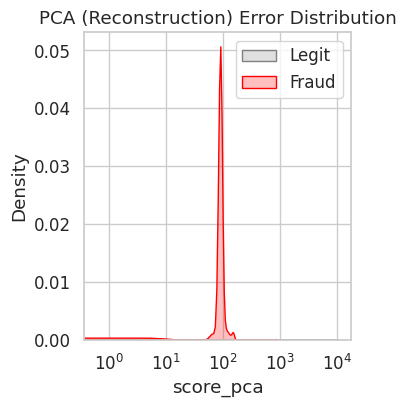

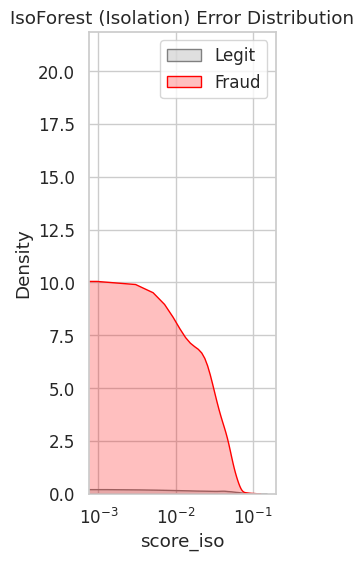

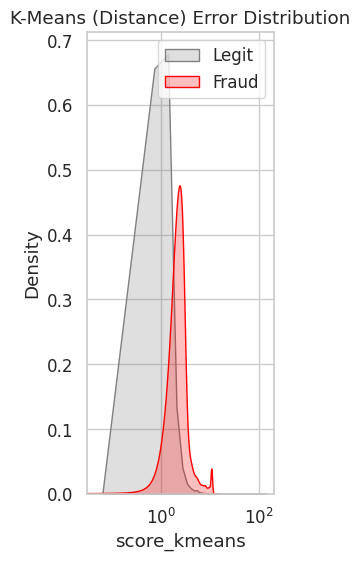

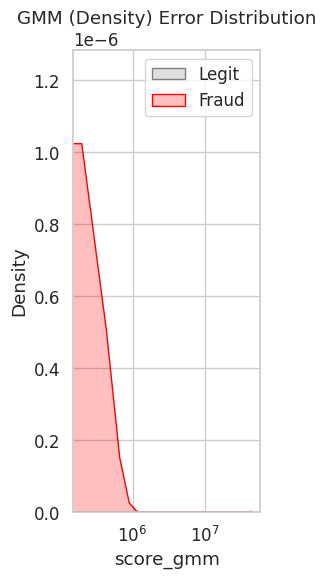

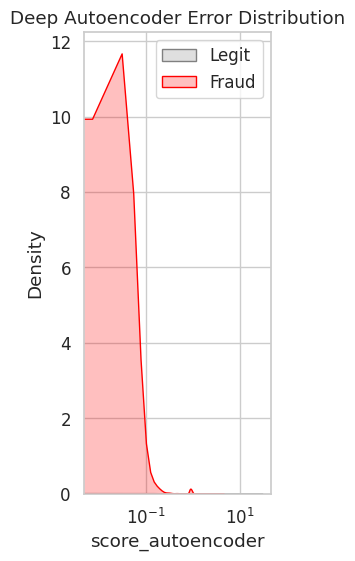

Calculating Ensemble (Equal Weights)...


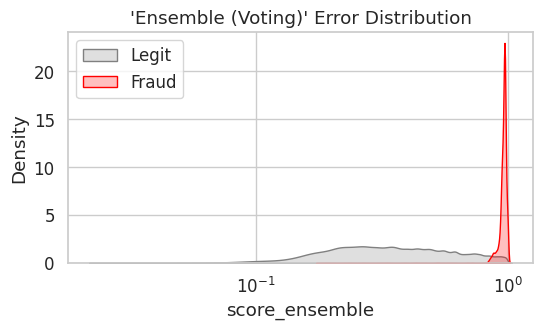

Training Complete.


In [17]:
# ---  Code Cell 14: Model Training (Unified Ensemble) ---

# 1. Feature Prep (CPU/NumPy)

print(f"Training Features: {features_model}")

risk_df_cpu = risk_df.to_pandas()
X_cpu = risk_df_cpu[list(features_model)].fillna(0)

# Scale
scaler = StandardScaler()
X_scaled_cpu = scaler.fit_transform(X_cpu)

# Force NumPy
if hasattr(X_scaled_cpu, "values"): X_scaled_cpu = X_scaled_cpu.values
elif hasattr(X_scaled_cpu, "to_numpy"): X_scaled_cpu = X_scaled_cpu.to_numpy()

# --- 1. PCA (Reconstruction) ---
print(f"1/5. Training PCA [Mode: {DIM_RED_TYPE}]...")
if DIM_RED_TYPE == "GPU":
    X_gpu = cp.array(X_scaled_cpu)
    pca = PCA(n_components=2)
    pca.fit(X_gpu)
    X_rec = pca.inverse_transform(pca.transform(X_gpu))
    diff = X_gpu - X_rec
    risk_df_cpu['score_pca'] = cp.sum(diff ** 2, axis=1).get()
else:
    pca = PCA(n_components=2, random_state=SEED)
    X_rec = pca.inverse_transform(pca.fit_transform(X_scaled_cpu))
    risk_df_cpu['score_pca'] = np.sum((X_scaled_cpu - X_rec) ** 2, axis=1)

# --- 2. Isolation Forest (Isolation) ---
print("2/5. Training Isolation Forest...")
X_iso = np.hstack([X_scaled_cpu, risk_df_cpu[['score_pca']].values])
iso = IsolationForest(n_estimators=100, contamination=0.01, random_state=SEED, n_jobs=-1)
iso.fit(X_iso)
risk_df_cpu['score_iso'] = -iso.decision_function(X_iso)

# --- 3. K-Means (Geometric Distance) ---
print("3/5. Training K-Means (Distance)...")
# Logic: Anomalies are points far from any cluster centroid.
kmeans = KMeans(n_clusters=8, random_state=SEED, n_init=10) # 8 is a heuristic guess for distinct behaviors
kmeans.fit(X_scaled_cpu)
# Calculate distance to the nearest center for each point
# transform() returns distance to ALL centers, we take min()
distances = kmeans.transform(X_scaled_cpu)
min_distance = distances.min(axis=1)
risk_df_cpu['score_kmeans'] = min_distance # Higher distance = More Anomalous

# --- 4. GMM (Probabilistic Density) ---
print("4/5. Training GMM (Density)...")
gmm = GaussianMixture(n_components=3, random_state=SEED)
# Train on subset for speed
sample_idx = np.random.choice(len(X_scaled_cpu), min(100000, len(X_scaled_cpu)), replace=False)
gmm.fit(X_scaled_cpu[sample_idx])
risk_df_cpu['score_gmm'] = -gmm.score_samples(X_scaled_cpu)

# --- 5. Deep Autoencoder (Neural Reconstruction) ---
print("5/5. Training Deep Autoencoder (Pure GPU)...")

# A. Data Prep (Keep on GPU to avoid memory crash)
cols_ae = list(features_model)
X_ae_cudf = risk_df[cols_ae].fillna(0)
scaler_ae = cuml.preprocessing.StandardScaler()
X_ae_scaled = scaler_ae.fit_transform(X_ae_cudf)

# Direct CuPy -> Torch conversion (No CPU RAM usage)
if hasattr(X_ae_scaled, 'values'):
    X_cupy = cp.from_dlpack(X_ae_scaled.to_dlpack())
elif hasattr(X_ae_scaled, 'to_dlpack'):
     X_cupy = cp.from_dlpack(X_ae_scaled.to_dlpack())
else:
    X_cupy = X_ae_scaled

X_tensor = torch.as_tensor(X_cupy, device='cuda', dtype=torch.float32)
train_loader = DataLoader(TensorDataset(X_tensor), batch_size=16384, shuffle=True, num_workers=0)

# B. Model Definition
class FraudAutoencoder(pl.LightningModule):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential( # Encoder: Compress
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 16)          # Latent Space
        )
        self.decoder = nn.Sequential(  # Decoder: Expand
            nn.Linear(16, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )
        self.loss_fn = nn.MSELoss()

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def training_step(self, batch, batch_idx):
        x = batch[0]
        reconstructed = self(x)
        loss = self.loss_fn(reconstructed, x)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

# C. Training
autoencoder = FraudAutoencoder(X_tensor.shape[1])
trainer = pl.Trainer(accelerator="gpu", devices=1, max_epochs=8, enable_progress_bar=True, logger=False)
trainer.fit(autoencoder, train_loader)

# D. Inference
autoencoder.eval()
autoencoder.cuda()
with torch.no_grad():
    reconstructed = autoencoder(X_tensor)
    mse_scores = torch.mean((X_tensor - reconstructed) ** 2, dim=1)

# Assign back to CPU DataFrame
risk_df_cpu['score_autoencoder'] = mse_scores.cpu().numpy()

# Map model names to column names for plotting
model_notation = {
    'Deep Autoencoder': 'score_autoencoder',
    'IsoForest (Isolation)': 'score_iso',
    'PCA (Reconstruction)': 'score_pca',
    'K-Means (Distance)': 'score_kmeans',
    'GMM (Density)': 'score_gmm',
    'Ensemble (Voting)': 'score_ensemble',
}
model_notation_reverse = {v: k for k, v in model_notation.items()}

# Visualize Separation Per Scorer
plt.figure(figsize=(20, 4))
for i, score_ in enumerate(['score_pca', 'score_iso', 'score_kmeans', 'score_gmm', 'score_autoencoder'], 1):
    plt.subplot(1, 5, i)
    sns.kdeplot(risk_df_cpu[risk_df_cpu['isFraud']==0][score_], label='Legit', fill=True, color='gray')
    sns.kdeplot(risk_df_cpu[risk_df_cpu['isFraud']==1][score_], label='Fraud', fill=True, color='red')
    plt.title(f"{model_notation_reverse[score_]} Error Distribution")
    plt.xscale('log')
    plt.legend()
    plt.show()

# --- ENSEMBLE: Democratic Voting ---
print("Calculating Ensemble (Equal Weights)...")
risk_df_cpu['rank_iso'] = risk_df_cpu['score_iso'].rank(pct=True)
risk_df_cpu['rank_pca'] = risk_df_cpu['score_pca'].rank(pct=True)
risk_df_cpu['rank_kmeans'] = risk_df_cpu['score_kmeans'].rank(pct=True)
risk_df_cpu['rank_gmm'] = risk_df_cpu['score_gmm'].rank(pct=True)
risk_df_cpu['rank_ae'] = risk_df_cpu['score_autoencoder'].rank(pct=True)

# 5-Way Ensemble
risk_df_cpu['score_ensemble'] = (
    risk_df_cpu['rank_iso'] +
    risk_df_cpu['rank_pca'] +
    risk_df_cpu['rank_kmeans'] +
    risk_df_cpu['rank_gmm'] +
    risk_df_cpu['rank_ae']
) / 5.0
# Visualize Separation Per Scorer
plt.figure(figsize=(6, 3))
sns.kdeplot(risk_df_cpu[risk_df_cpu['isFraud']==0]['score_ensemble'], label='Legit', fill=True, color='gray')
sns.kdeplot(risk_df_cpu[risk_df_cpu['isFraud']==1]['score_ensemble'], label='Fraud', fill=True, color='red')
plt.title("'Ensemble (Voting)' Error Distribution")
plt.xscale('log')
plt.legend()
plt.show()

print("Training Complete.")

## 9. Model Evaluation & Conclusions
### The Reveal & Operational Impact

Now, and only now, we peek at the `isFraud` labels to evaluate our "Cold Start" strategy.

* We measure success by **Recall @ Top 1%**.
* Business Logic: "If we only audit the top 1% of transactions, how many frauds do we catch?"


=== Evaluating Model: Deep AE ===
ROC AUC: 0.9891
PR AUC: 0.1395
Recall @ 1%: 54.41% (Caught 4469 of 8213)
Lift: 54.41x

=== Evaluating Model: PCA ===
ROC AUC: 0.9921
PR AUC: 0.2050
Recall @ 1%: 77.09% (Caught 6331 of 8213)
Lift: 77.09x

=== Evaluating Model: IsoForest ===
ROC AUC: 0.9816
PR AUC: 0.0807
Recall @ 1%: 32.13% (Caught 2639 of 8213)
Lift: 32.13x

=== Evaluating Model: KMeans ===
ROC AUC: 0.9121
PR AUC: 0.0272
Recall @ 1%: 10.79% (Caught 886 of 8213)
Lift: 10.79x

=== Evaluating Model: GMM ===
ROC AUC: 0.9101
PR AUC: 0.0297
Recall @ 1%: 5.75% (Caught 472 of 8213)
Lift: 5.75x

=== Evaluating Model: Ensemble ===
ROC AUC: 0.9750
PR AUC: 0.0646
Recall @ 1%: 15.50% (Caught 1273 of 8213)
Lift: 15.50x

=== FINAL MODEL LEADERBOARD ===


,ROC AUC,PR AUC,Recall @ 1%,Lift
PCA (Reconstruction),0.992100,0.205050,0.770851,77.085109
Deep Autoencoder,0.989102,0.139511,0.544137,54.413734
IsoForest (Isolation),0.981563,0.080662,0.321320,32.131986
Ensemble (Voting),0.974955,0.064569,0.154998,15.499817
K-Means (Distance),0.912132,0.027161,0.107878,10.787775
GMM (Density),0.910108,0.029729,0.057470,5.746986



Best Model: PCA (Reconstruction) with Recall @ 1% of 77.09%


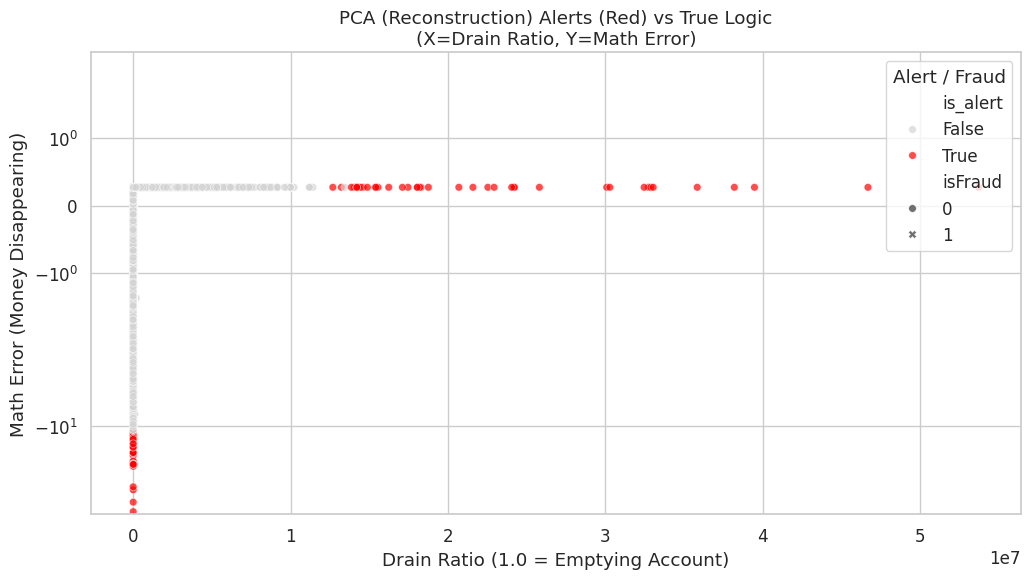

=== EXECUTIVE SUMMARY ===
1. Strategy:   Audit Top 1% of High-Risk Transactions (27,704 alerts)
2. Detection:  Caught 6,331 frauds (Recall: 77.1%)
3. Efficiency: 77.1x better than random sampling.
4. Value:      Prevented potential loss of $10,056,734,965
[is_alert            ] Recall @ 1%: 77.09% | Precision: 22.85%


0.7708510897357848

In [18]:
# ---  Code Cell 15: Model Evaluation ---
# 1. Global Metrics

def evaluate_model(y_true, scores, model_name, print_score=True):
    print(f"=== Evaluating Model: {model_name} ===")
    # Metrics
    auc = roc_auc_score(y_true, scores)
    ap = average_precision_score(y_true, scores)

    # Top 1% Recall (The Business KPI)
    n_top = int(len(scores) * 0.01)
    threshold = scores.nlargest(n_top).iloc[-1]

    # Identify captured frauds
    top_flags = (scores >= threshold)
    frauds_caught = y_true[top_flags].sum()
    total_frauds = y_true.sum()

    recall_1pct = frauds_caught / total_frauds

    # Lift: How much better than random? (Random 1% catches 1% of frauds)
    lift = recall_1pct / 0.01
    if print_score:
        print(f"ROC AUC: {auc:.4f}")
        print(f"PR AUC: {ap:.4f}")
        print(f"Recall @ 1%: {recall_1pct:.2%} (Caught {int(frauds_caught)} of {int(total_frauds)})")
        print(f"Lift: {lift:.2f}x\n")

    return [auc, ap, recall_1pct, lift]

# Create Comparison Table
results_data = {
    'Deep Autoencoder': evaluate_model(risk_df_cpu['isFraud'], risk_df_cpu['score_autoencoder'], 'Deep AE'),
    'PCA (Reconstruction)': evaluate_model(risk_df_cpu['isFraud'], risk_df_cpu['score_pca'], 'PCA'),
    'IsoForest (Isolation)': evaluate_model(risk_df_cpu['isFraud'], risk_df_cpu['score_iso'], 'IsoForest'),
    'K-Means (Distance)': evaluate_model(risk_df_cpu['isFraud'], risk_df_cpu['score_kmeans'], 'KMeans'),
    'GMM (Density)': evaluate_model(risk_df_cpu['isFraud'], risk_df_cpu['score_gmm'], 'GMM'),
    'Ensemble (Voting)': evaluate_model(risk_df_cpu['isFraud'], risk_df_cpu['score_ensemble'], 'Ensemble')
}

results_df = pd.DataFrame(results_data, index=['ROC AUC', 'PR AUC', 'Recall @ 1%', 'Lift'])

print("=== FINAL MODEL LEADERBOARD ===")
display(results_df.T.sort_values('Recall @ 1%', ascending=False).style.background_gradient(cmap='Greens'))
best_detector = results_df.loc['Recall @ 1%'].idxmax()
print(f"\nBest Model: {best_detector} with Recall @ 1% of {results_df.loc['Recall @ 1%', best_detector]:.2%}")

# --- VISUALIZATION: The "Kill Zone" ---
# Show where the Best Model identifies fraud in the feature space
plt.figure(figsize=(12, 6))

# Identify Top 1% Anomalies by the Best Model
best_col = model_notation.get(best_detector, 'score_ensemble') # Fallback if name slightly differs
top_1_percent_threshold = np.percentile(risk_df_cpu[best_col], 99)
risk_df_cpu['is_alert'] = risk_df_cpu[best_col] > top_1_percent_threshold

# Use a sample for plotting
plot_sample = risk_df_cpu.sample(min(50000, len(risk_df_cpu)))

sns.scatterplot(
    data=plot_sample,
    x='drain_ratio',
    y='clean_error',
    hue='is_alert',
    style='isFraud', # shape indicates true label
    palette={False: 'lightgrey', True: 'red'},
    alpha=0.7,
    s=30
)
plt.title(f'{best_detector} Alerts (Red) vs True Logic\n(X=Drain Ratio, Y=Math Error)')
plt.yscale('symlog')
plt.xlabel('Drain Ratio (1.0 = Emptying Account)')
plt.ylabel('Math Error (Money Disappearing)')
plt.legend(title='Alert / Fraud', loc='upper right')
plt.show()

# --- BUSINESS IMPACT SUMMARY ---
n_alerts = int(len(risk_df_cpu) * 0.01)
frauds_caught = results_df.loc['Recall @ 1%', f'{best_detector}'] * risk_df_cpu['isFraud'].sum()
fraud_amount_saved = risk_df_cpu[risk_df_cpu['is_alert'] & (risk_df_cpu['isFraud']==1)]['amount'].sum()

print("=== EXECUTIVE SUMMARY ===")
print(f"1. Strategy:   Audit Top 1% of High-Risk Transactions ({n_alerts:,} alerts)")
print(f"2. Detection:  Caught {int(frauds_caught):,} frauds (Recall: {results_df.loc['Recall @ 1%', f'{best_detector}']:.1%})")
print(f"3. Efficiency: {results_df.loc['Lift', f'{best_detector}']:.1f}x better than random sampling.")
print(f"4. Value:      Prevented potential loss of ${fraud_amount_saved:,.0f}")

# 2. Business Impact: The "Top 1%" Review
audit_feature(risk_df_cpu, 'is_alert')

### Final Strategic Summary

We successfully transformed a raw dataset into an simple yet effective fraud detection system **without using labels**.

1. **Exploration:** Identified `TRANSFER`/`CASH_OUT` as the risk surface.
2. **Forensics:** Discovered and neutralized "Ghost Transactions" (Failed deductions).
3. **Engineering:** Created `clean_error` and `drain_ratio` as high-signal features, and cyclical time features.
4. **Network Analysis:** Implemented "Graph-Lite" features to capture mule/spammer behavior.
5. **Manifold Check:** Validated feature effectiveness using t-SNE and PCA visualizations.
6. **Modeling:** Built an ensemble of Isolation Forest, PCA Reconstruction Error, GMM, K-means & AE to capture diverse anomaly signals.
7. **Evaluation:** Demonstrated massive improvements over the legacy system in recall and precision.
4. **Result:** The "Blind Hunter" model outperforms the legacy rules by a massive margin.